In [1]:
''' 
Unified Figure Maker

To Do: Give a description of the code
Describe where each plot comes from and how the data is made.

'''

' \nUnified Figure Maker\n\nTo Do: Give a description of the code\nDescribe where each plot comes from and how the data is made.\n\n'

In [2]:
import sys, os, time, fileinput
import numpy as np
import math as math 
from scipy.stats import maxwell, rv_histogram
import scipy.optimize as optimize
from scipy.interpolate import interp1d
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib import colors
from matplotlib.ticker import FormatStrFormatter

from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.table import Table

plt.style.use('default') 

rcParams.update({'figure.autolayout': True})
plt.rc('font', family='serif')
mpl.mathtext.fontset : 'dejavusans'

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 30
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 20
mpl.rc('axes',edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
mpl.rcParams['agg.path.chunksize'] = 10000
mpl.rcParams['text.usetex'] = True

fontsize=30

/tmp/ipykernel_1977/3444432276.py:30: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'png')


In [3]:
''' 
Figure 1. Catalog of binaries produced by EBR2021 

purpose: show separation distribution and expected number of contaminants
data: data/all_columns_catalog.fits 

Special Requirement: 
* Need to download all_columns_catalog.fits file from arXiv:2101.05282v3
     - Quick link to catalog: https://zenodo.org/record/4435257

'''

dat = Table.read('data/all_columns_catalog.fits', format='fits')
cdf = dat.to_pandas()

pc_AU = 4.84814e-6 # pc/AU
cdf['sep_pc'] = cdf['sep_AU'] * pc_AU

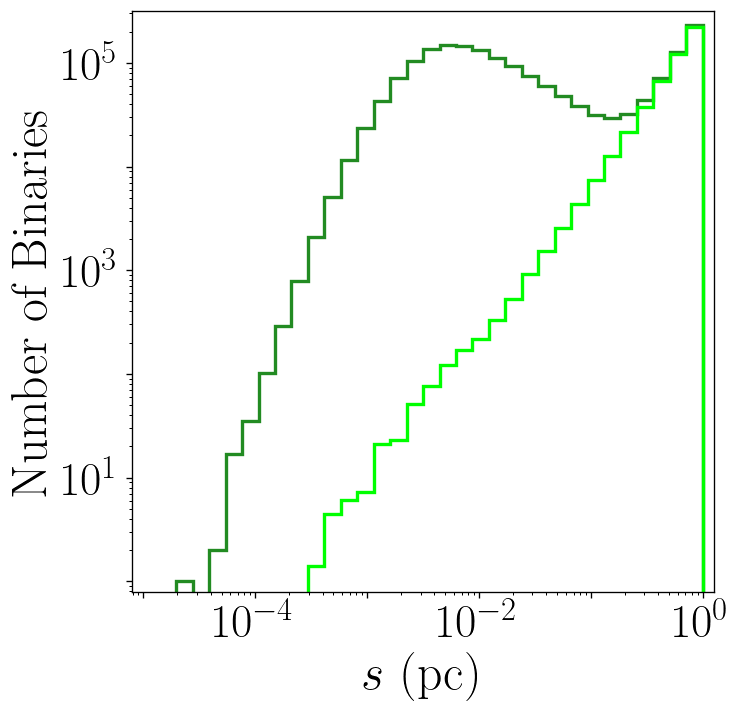

In [4]:
fig_data_uncut = plt.figure(figsize=(6, 5.75), dpi= 120)

ax = fig_data_uncut.add_subplot(111)

def capper_(x):
    if x < 1:
        return x
    else:
        return 1
capper_vec = np.vectorize(capper_)

counts, bins, _ = ax.hist((cdf['sep_pc']) , bins = np.logspace(-5,0,35), color = 'forestgreen', alpha = 1, lw = 2, histtype = 'step', density = False)
counts, bins, _ = ax.hist((cdf['sep_pc']) , bins = np.logspace(-5,0,35), color = 'lime', alpha = 1, lw = 2, histtype = 'step'
                          , density = False, weights = capper_vec(cdf['R_chance_align']))
ax.set_xlabel('$s \ (\\rm{pc})$',fontsize=fontsize)
ax.set_ylabel('Number of Binaries',fontsize=fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**-5.1,10**0.1])
ax.set_ylim([10**-0.1,10**5.5])

ax.set_xticks(np.logspace(-4,0,3))
ax.tick_params(axis='both',labelsize=28)

# Turning on minor tick marks for log-scaled plots


locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)
ax.xaxis.set_minor_locator(locmin_x)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# This allows us to manually modify tick labels
ax.set_xticks(np.logspace(-5,0,6))
plt.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
for n in range(0,len(labels),2): labels[n] = ' ' 
    
ax.set_xticklabels(labels)

locmin_y = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)
ax.yaxis.set_minor_locator(locmin_y)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
fig_data_uncut.tight_layout(pad = 0)

ax.set_yticks(np.logspace(0,5,6))
plt.draw()

labels = [item.get_text() for item in ax.get_yticklabels()]
for n in range(0,len(labels),2): labels[n] = ' ' 
    
ax.set_yticklabels(labels)

fig_data_uncut.savefig('figures/fig-data-uncut-v0.8.pdf', format = 'pdf', bbox_inches='tight')

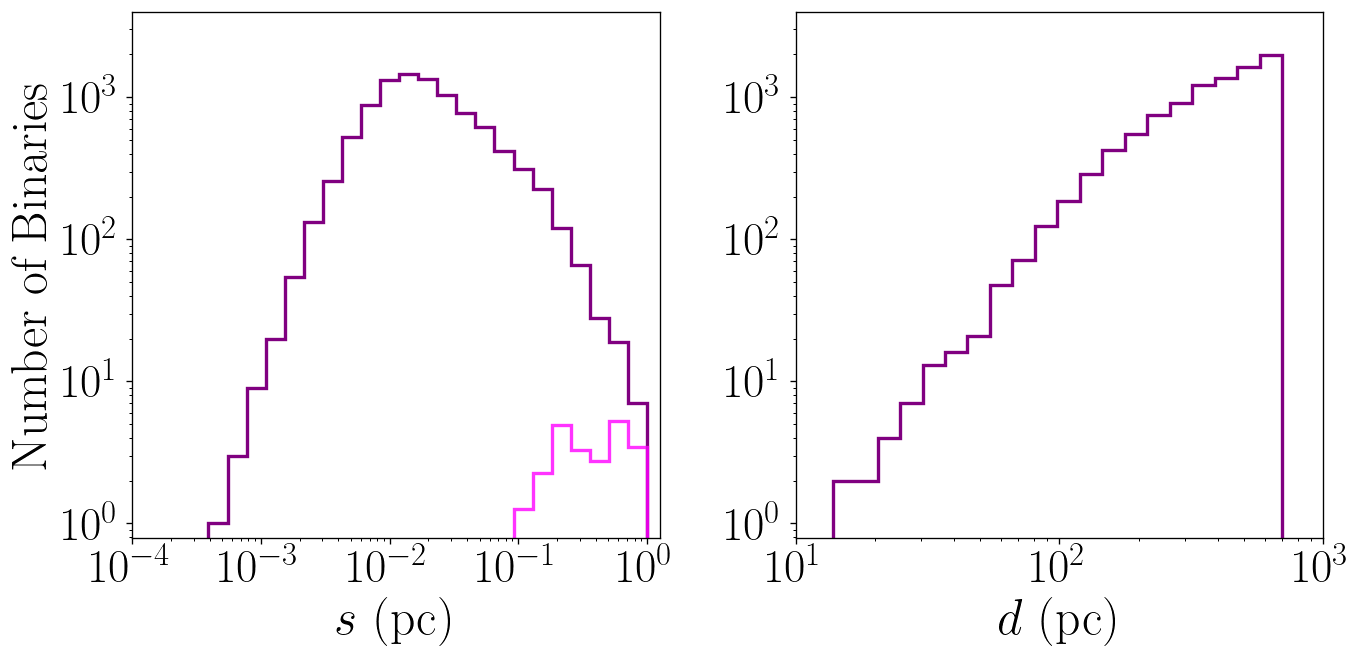

In [5]:
''' 
Figure 2. Final sample of binaries after applying all quality cuts

purpose: show separation distribution and expected number of contaminants ; show distribution of distances from Earth
data: data/halo_catalog_dataframe.pkl
source: D:/dmbinaries_local/DR3 Data/catalog_data_analysis_edr3_quick.ipynb
    cleaner but incomplete file: catalog_data_analysis_edr3.ipynb

Note: The data we load does not include the cut that was made using the selection function f_\Delta G.
        Therefore, we load the dataset and perform the cut here before plotting the separation distribution.
'''

cdf_halo = pd.read_pickle('data/halo_catalog_dataframe.pkl')
cdf_halo['distance1'] = 1000 * (1/cdf_halo['parallax1'])    # pc
cdf_halo['delta_G'] = np.abs(cdf_halo['phot_g_mean_mag1'] - cdf_halo['phot_g_mean_mag2'])  # mag

delta_G_mid = [0.5,1.5,2.5,3.5,5,7,9.5]
theta_cut_vals = [3.06481262,  3.26382633,  3.94047254,  4.61711977,  6.24903233,  9.55266057, 11.98062847]
theta_cut_ = interp1d(delta_G_mid, theta_cut_vals, kind = 'linear', fill_value = 'extrapolate', assume_sorted = True)

cdf_halo['theta_cut'] = theta_cut_(cdf_halo['delta_G'])
cdf_theta_cut = cdf_halo[ cdf_halo['pairdistance_arcsec'] > cdf_halo['theta_cut'] ]
cdf_theta_cut.reset_index(drop=True, inplace=True)

cdf_halo = cdf_theta_cut

fig_data = plt.figure(figsize=(12, 6.125), dpi= 120)

ax = fig_data.add_subplot(121)
counts, bins, _ = ax.hist((cdf_halo['sep_pc']) , bins = np.logspace(-4,0,28), color = 'purple', alpha = 1, lw = 2, histtype = 'step'
                          , density = False)
counts, bins, _ = ax.hist((cdf_halo['sep_pc']) , bins = np.logspace(-4,0,28), color = 'magenta', alpha = 0.8, lw = 2, histtype = 'step'
                          , density = False, weights = cdf_halo['R_chance_align'])
ax.set_xlabel('$s \ (\\rm{pc})$',fontsize=fontsize)
ax.set_ylabel('Number of Binaries',fontsize=fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**-4,10**0.1])
ax.set_ylim([10**-0.1,10**3.6])
ax.tick_params(axis='both',labelsize=28)

#ax.grid()
ax.set_xticks(np.logspace(-4,0,5))
#ax.set_yticks(np.logspace(0,3,4))
#ax.tick_params(direction='out', colors='k',
#               grid_color='k', grid_alpha=0.25)
#ax.xaxis.ticklabel_format(useMathText=True)
#ax.yaxis.ticklabel_format(useMathText=True)
#ax.xaxis.set_major_formatter(logfmt)
#ax.yaxis.set_major_formatter(logfmt)

# Turning on minor tick marks for log-scaled plots

locmin_x = mpl.ticker.LogLocator(base=10.0,subs=None,numticks=5)
ax.xaxis.set_minor_locator(locmin_x)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

#locmin_y = mpl.ticker.LogLocator(base=10.0,subs=None,numticks=4)
#ax.yaxis.set_minor_locator(locmin_y)
#ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax = fig_data.add_subplot(122)
counts, bins, _ = ax.hist((cdf_halo['d_p']) , bins = np.logspace(np.log10(np.min(cdf_halo['d_p'])),np.log10(np.max(cdf_halo['d_p'])),28), 
                          color = 'purple', alpha = 1, histtype = 'step', lw = 2, density = False)
ax.set_xlabel('$d \ (\\rm{pc})$',fontsize=fontsize)
#ax.set_ylabel('Number of Binaries')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10,10**3])
ax.set_ylim([10**-0.1,10**3.6])
ax.tick_params(axis='both',labelsize=28)

#ax.grid()
#ax.set_xticks(np.logspace(1,3,3))
#ax.set_yticks(np.logspace(0,3,4))
#ax.tick_params(direction='out', colors='k',
#               grid_color='k', grid_alpha=0.25)
#ax.xaxis.ticklabel_format(useMathText=True)
#ax.yaxis.ticklabel_format(useMathText=True)
#ax.xaxis.set_major_formatter(logfmt)
#ax.yaxis.set_major_formatter(logfmt)

# Turning on minor tick marks for log-scaled plots

#locmin_x = mpl.ticker.LogLocator(base=10.0,subs=None,numticks=5)
#ax.xaxis.set_minor_locator(locmin_x)
#ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

#locmin_y = mpl.ticker.LogLocator(base=10.0,subs=None,numticks=4)
#ax.yaxis.set_minor_locator(locmin_y)
#ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

fig_data.tight_layout(pad = 1)

fig_data.savefig('figures/fig-data-v0.8.pdf', format = 'pdf', bbox_inches='tight')

PyMultiNest not imported.  MultiNest fits will not work.


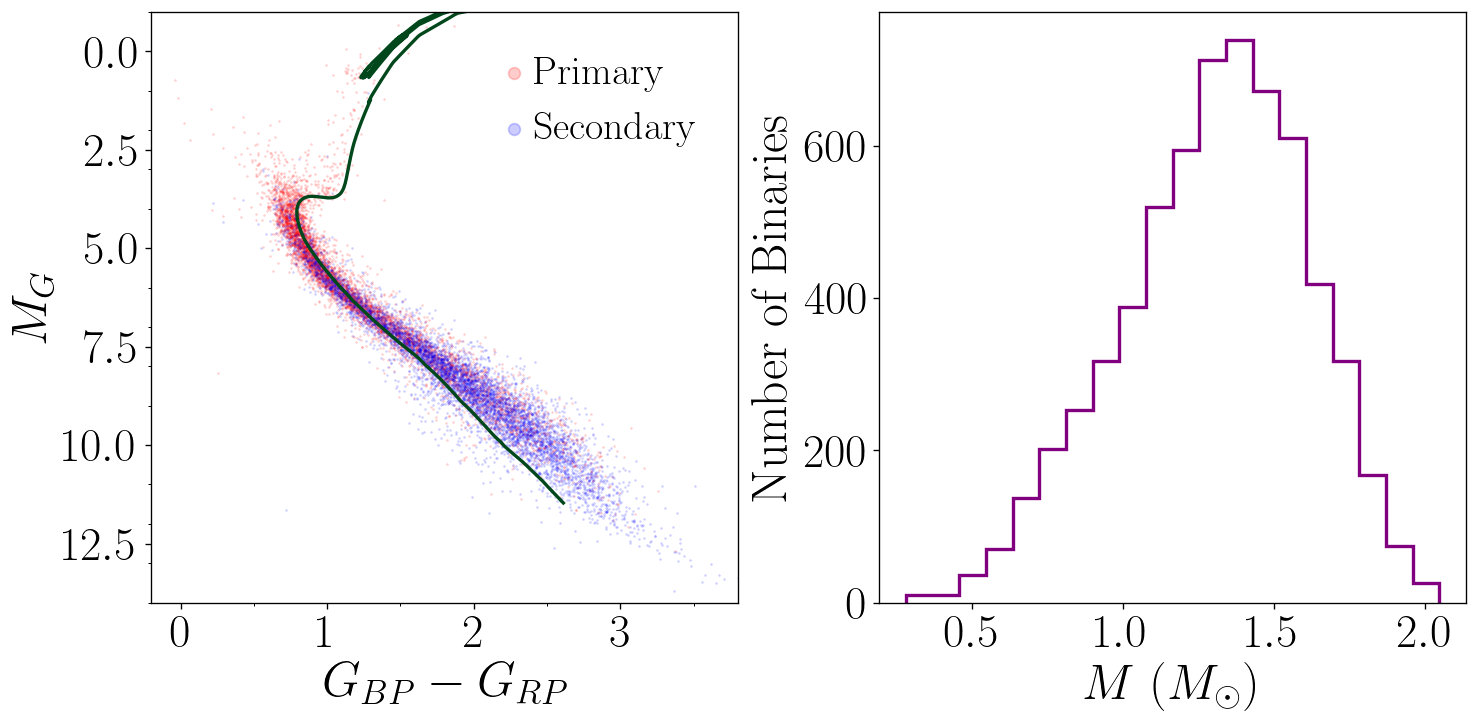

In [6]:
''' 
Figure 3. Sample photometric data and mass estimates

purpose: Show photometric data in the form of a CMD ; show mass estimates of stars after correcting 
            for extinction and interpolating over isochrones

data: data/halo_catalog_dataframe.pkl
        data/isochrone_10_0.pkl
        
source: D:/dmbinaries_local/DR3 Data/catalog_data_analysis_edr3_quick.ipynb
    cleaner but old and incomplete file: catalog_data_analysis_edr3.ipynb

'''

midf = pd.read_pickle('data/isochrone_10_0.pkl')

fig_mass = plt.figure(figsize=(12, 6), dpi= 120)

ax = fig_mass.add_subplot(121)

from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

Age = 10
log_Age = np.log10(Age * 10**9) # log_10 (Age/yr)
MH_list = [0] # [M/H] in units of dex
N_MH = len(MH_list)

## Isochrone plots
# Set color gradient of isochrone plots
cmap = plt.get_cmap('Greens')
color_code = 0.99
color = cmap(color_code)

ax.plot(midf['color'], midf['mg'], lw = 2, color = color, markersize = 1, alpha = 1)

# l1 = ax.legend(['Isochrone'], frameon = False, ncol=1, handletextpad=0.25, borderpad=0.25, 
#                handlelength = 1, loc='lower left', bbox_to_anchor=(-0.03, 0.12, 0, 0.5))
# ax.add_artist(l1)
# ax.tick_params(axis='both', which='major')

## CMD of primaries and secondaries
ax.scatter(cdf_halo['color_int_p'], cdf_halo['mg_int_p'], s = 0.225, c = 'r', alpha = 0.2, label = 'Primary')
ax.scatter(cdf_halo['color_int_s'], cdf_halo['mg_int_s'], s = 0.225, c = 'b', alpha = 0.2, label = 'Secondary') 

ax.set_xlim([-0.2,3.8])
ax.set_ylim([-1,14])
locmin_x = mpl.ticker.MultipleLocator(0.5)
ax.xaxis.set_minor_locator(locmin_x)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
locmin_y = mpl.ticker.MultipleLocator(1)
ax.yaxis.set_minor_locator(locmin_y)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax.invert_yaxis()
ax.set_xlabel('$G_{BP} - G_{RP}$',fontsize=fontsize)
ax.set_ylabel('$M_{G}$',fontsize=fontsize)
ax.tick_params(axis='both',labelsize=28)
lgnd = ax.legend(ncol=1, frameon = False, handletextpad=0.25, 
                 borderpad=0.25, handlelength = 0.5, loc='lower left', bbox_to_anchor=(0.55, 0.72, 0, 0.5), fontsize = 24)
for n in range(N_MH+1):
    lgnd.legendHandles[n]._sizes = [50]
# ax.set_title(str(Age) + ' Gyr Isochrones')
ax.tick_params(axis='both', which='major')

# ax.text(-0.1, 12.15, '$\\rm{Age} = 10 \ \\rm{Gyr}$', style='normal', fontsize = 28)
# ax.text(-0.1, 13.5, '$\\rm{[Fe/H]} = 0.0 \ \\rm{dex}$', style='normal', fontsize = 28)

ax = fig_mass.add_subplot(122)
counts, bins, _ = ax.hist((cdf_halo['M']) , bins = np.linspace(np.min(cdf_halo['M']),np.max(cdf_halo['M']),21), 
                          color = 'purple', alpha = 1, histtype = 'step', lw = 2, density = False)
ax.set_xlabel('$M \ (M_{\odot})$',fontsize=fontsize)
ax.set_ylabel('Number of Binaries',fontsize=fontsize)
ax.set_xticks(np.arange(0.5, 2+0.5, 0.5))
ax.tick_params(axis='both', which='major')

ax.tick_params(axis='both',labelsize=28)
# ax.set_ylim([0,3])

fig_mass.tight_layout(pad = 0.2)

fig_mass.savefig('figures/fig-mass-v0.8.pdf', format = 'pdf', bbox_inches='tight')

Figure 4. Perturber-binary interaction geometry

purpose: show coordinate system used to describe encounters

data: drawn with ppt

source: C:\Users\Edwar\Dropbox\dmbinaries\Paper\Figures\v0.6 (eDR3)\figures_v0.1.ppt



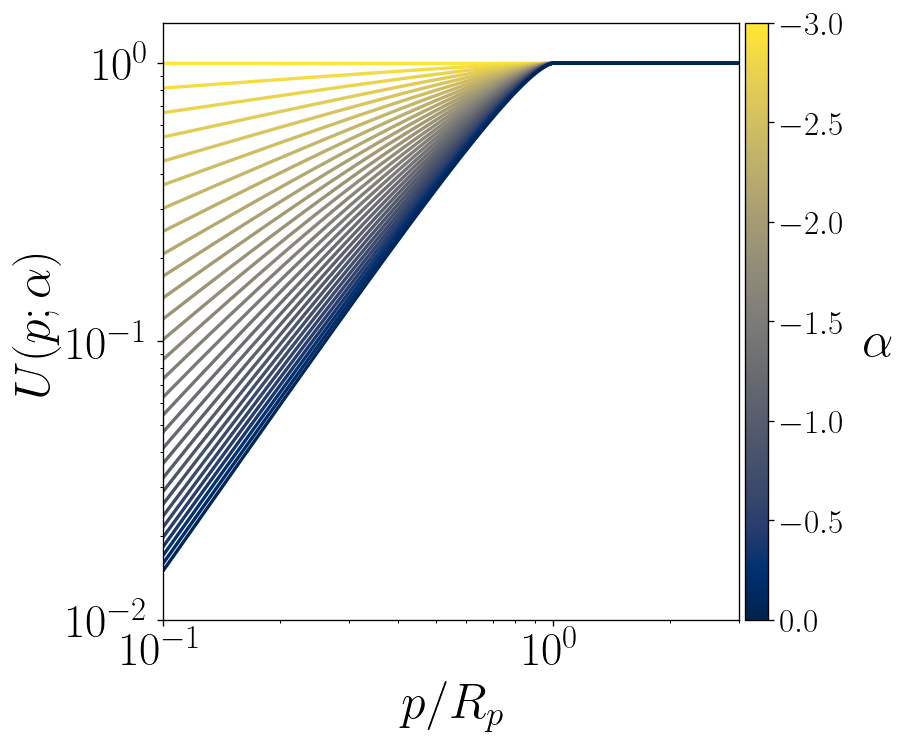

In [7]:
''' 
Figure 5. U(p) for perturbers with power-law density profiles

purpose: show how the structure function behaves for generic perturbers

data: no data required
        
source: D:\dmbinaries_local\Code\elliptic\Figures_v2\theory.ipynb

'''

from scipy.special import hyp2f1

def U_arb_(p,R,alpha):
    if p < R:
        return ( 1 - (p*math.sqrt(-1 + R*R/p/p))/R + 
                (p*p*p*p*math.sqrt(-1 + R*R/p/p)*hyp2f1(0.5,(3 + alpha)/2.,1.5,1 - p*p/R/R))/(R*R*R*R*(R/p)**alpha) )
    else:
        return 1
    
U_arb_vec_ = np.vectorize(U_arb_) 
alpha_list = np.linspace(-3,0,30)
Na = len(alpha_list)

# -----

fig_u = plt.figure(figsize=(7.35,6), dpi= 120)
ax = fig_u.add_subplot(111)

rs = 100

# Set color gradient of plots
cmap = plt.get_cmap('cividis')

# Plot the data
color_code = 0.99
color = cmap(color_code)

rlist = np.logspace(-1,1,1000)
for alpha in alpha_list:
    if alpha == 2:
        ax.plot(rlist,U_arb_vec_(rlist*rs,rs,alpha), lw = 2, c=color, alpha = 1, label = 'Power Law')
        continue
        
    ax.plot(rlist,U_arb_vec_(rlist*rs,rs,alpha), lw = 2, c=color, alpha = 1)
    color_code -= 1/(Na); color = cmap(color_code)
        
ax.set_xlabel('$p/R_{p}$',fontsize=fontsize)
ax.set_ylabel('$U(p;\\alpha)$',fontsize=fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1,3)
ax.set_ylim(0.01,1.4)

ax.tick_params(axis='both',labelsize=28)

# setup the normalization and the colormap
normalize = mpl.colors.Normalize(vmin=-3, vmax=0)
colormap = mpl.cm.cividis_r

# setup the colorbar
scalarmappaple = mpl.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(np.flip(np.linspace(-3,0,30)))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)

cb = plt.colorbar(scalarmappaple,cax=cax)
cb.ax.invert_yaxis()
#cb.ax.set_ylabel('$\\alpha$', rotation = 0)#, labelpad = -50, y = 0, fontsize = 30)
cb.set_label(r'$\alpha$',labelpad=+20, y=0.5,fontsize=fontsize,rotation=0)
cb.ax.tick_params(labelsize = 20)

fig_u.tight_layout(pad = 0)

fig_u.savefig('figures/fig-u-v0.8.pdf', format = 'pdf', bbox_inches='tight')

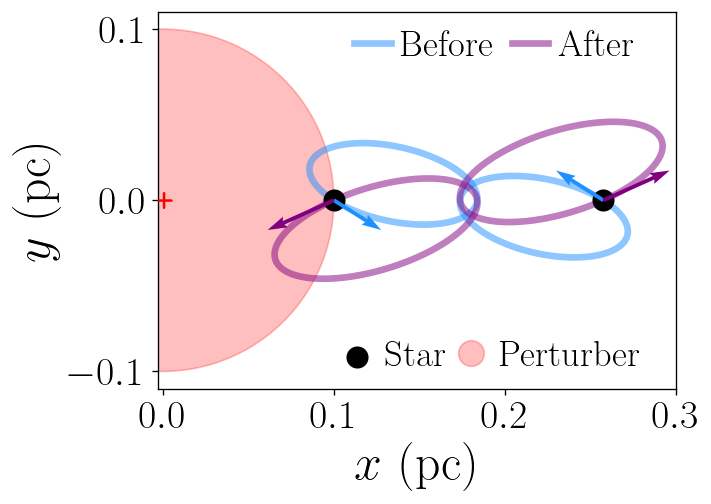

In [8]:
''' 
Figure 6. Result of single encounter on binary orbit

purpose: show how perturber changes the orbit of a binary

data: data/orbit_plot.npy
        
source: D:\dmbinaries_local\Code\elliptic\Figures_v2\orbit_plot.ipynb

'''

pre_encounter_coords, post_encounter_coords, vector_list  = np.load('data/orbit_plot.npy', allow_pickle = True)

M = 1
ai = 0.1
rs = 0.1
x1_list_0_translated_rotated, y1_list_0_translated_rotated, x2_list_0_translated_rotated, y2_list_0_translated_rotated  = pre_encounter_coords
x1_list_translated_rotated, y1_list_translated_rotated, x2_list_translated_rotated, y2_list_translated_rotated  = post_encounter_coords
origin, vectors = vector_list

# ---

# perturber position (valid for only perpendicular encounter)
fig_orbit = plt.figure(figsize=(6,4), dpi= 120)
ax = fig_orbit.add_subplot(111, aspect = 'equal')

ax.scatter(0, 0,c='r', zorder = 100, marker=r'$+$', s = 100)
from matplotlib.legend_handler import HandlerPatch


class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Ellipse(xy=center, width=height,
                             height=height)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

cir = plt.Circle((0, 0), rs, color='r',fill=True, alpha = 0.25, label = 'Perturber')
ax.add_patch(cir)

before_orbit, = ax.plot(x1_list_0_translated_rotated,y1_list_0_translated_rotated, ls = '-', color = 'dodgerblue',  alpha = 0.5, lw = 4, label = 'Before')
ax.plot(x2_list_0_translated_rotated,y2_list_0_translated_rotated, ls = '-', color = 'dodgerblue',  alpha = 0.5, lw = 4)

after_orbit, = ax.plot(x1_list_translated_rotated,y1_list_translated_rotated, ls = '-', color = 'purple', alpha = 0.5, lw = 4,  label = 'After')
ax.plot(x2_list_translated_rotated,y2_list_translated_rotated, ls = '-', color = 'purple', alpha = 0.5, lw = 4)
star = ax.scatter(x1_list_translated_rotated[0],y1_list_translated_rotated[0],c='k', zorder = 150, s = 150, label = 'Star')
ax.scatter(x2_list_translated_rotated[0],y2_list_translated_rotated[0],c='k', zorder = 150, s = 150)

ax.quiver(*origin, vectors[:,0], vectors[:,1], scale = 0.5, color = ['dodgerblue','purple'], zorder = 150, linewidth = 0.15)

ax.set_xlabel('$x$ (pc)', fontsize = fontsize)
ax.set_ylabel('$y$ (pc)', fontsize = fontsize)
ax.set_xlim([-0.0025,3*ai])
ax.set_ylim([-1.1*ai,1.1*ai])

l1 = ax.legend(handles = [before_orbit, after_orbit], frameon = False, ncol=2, handletextpad=0.25, borderpad=0.25, columnspacing = 0.5,
               handlelength = 1, loc='upper left', bbox_to_anchor=(0.225+0.1, 0.525, 0.5, 0.5), fontsize = 22)
ax.add_artist(l1)
ax.tick_params(axis='both', which='major', labelsize = 24)

from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
lgnd = ax.legend(handles = [star, cir], frameon = False, ncol=2, handletextpad=0.25, borderpad=0.25, columnspacing =0.2,
               handlelength = 1, loc='upper left', bbox_to_anchor=(0.2+0.095, 0.2), handler_map={mpatches.Circle: HandlerEllipse()}
                ,fontsize = 22)

fig_orbit.tight_layout(pad = 0)

fig_orbit.savefig('figures/fig-single-v0.8.pdf', format = 'pdf', bbox_inches='tight')

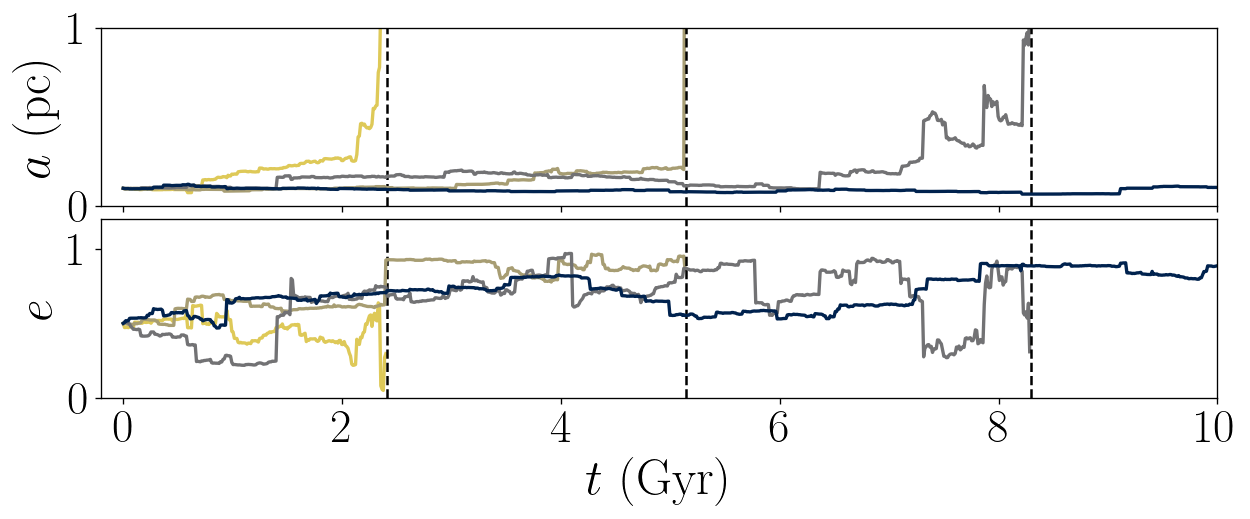

In [9]:
''' 
Figure 7. Result of many encounters on four binaries

purpose: show how many encounters changes orbits of binaries

data: data/individual_binary_evolution_data.npy
        
source:D:\dmbinaries_local\Code\elliptic\Figures_v2\single_binary_encounters_uniform.ipynb

NOTE: data saved, but due to random generation, cannot be replicated

'''

a0 = 0.1
e0 = 0.5
psii = 0 
Mp = 1000
# other parameters are standard

a_array, e_array = np.load('data/individual_binary_evolution_data_nv.npy', allow_pickle = True)
delta_t = 0.011538543721892662
N = 889

fig_time_evol = plt.figure(figsize=(12,4), dpi= 120)

plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['font.size'] = 30
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 28

ax1 = fig_time_evol.add_subplot(211)
ax2 = fig_time_evol.add_subplot(212,sharex=ax1)

# Set color gradient of plots
cmap = plt.get_cmap('cividis')

# Plot the data
color_codes = np.array([0.875, 0.675, 0.45, 0.0001,0])
ncolor = 0
color_code = color_codes[ncolor]
color = cmap(color_code)

#n_finite = np.where(a_array[:,-1] > 1)[0]
#n_gtr = np.where(a_array[:,-100] < 0.5)[0]
#print(np.intersect1d(n_finite, n_gtr))

binary_ids = [578, 500, 486, 5, 411, 170, 921]
binary_ids = [489, 237, 61, 33]
Nb = len(binary_ids)

for binary_id in binary_ids:
    ax1.plot(np.arange(0,N,1) * delta_t, a_array[binary_id,:], c = color)
    ax2.plot(np.arange(0,N,1) * delta_t, e_array[binary_id,:], c = color)
    
    n_time_disrupt = np.where(a_array[binary_id,:] == np.inf)[0]
    if len(n_time_disrupt) != 0:
        ax1.axvline(x = n_time_disrupt[0] * delta_t, ls = "--", c = 'k', lw = 1.5)
        ax2.axvline(x = n_time_disrupt[0] * delta_t, ls = "--", c = 'k', lw = 1.5)
    
    ncolor += 1
    color_code = color_codes[ncolor]
    color = cmap(color_code)
    
ax1.set_xlim([-0.2,10])
ax1.set_ylim([-0.0,1])
ax2.set_xlim([-0.2,10])
ax2.set_ylim([0,1.2])
ax2.set_xlabel('$t \ ({\\rm Gyr})$',fontsize=fontsize)
ax1.set_ylabel('$a \ ({\\rm pc})$',fontsize=fontsize)
ax2.set_ylabel('$e$')

ax1.tick_params(axis='both',labelsize=28)

ax2.tick_params(axis='both',labelsize=28)

ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelbottom=False) # labels along the bottom edge are off

plt.subplots_adjust(hspace=0.05*3/2)

#fig_time_evol.tight_layout(pad = 0.1)

fig_time_evol.savefig('figures/fig-time-evol-v0.8.pdf', format = 'pdf', bbox_inches='tight')

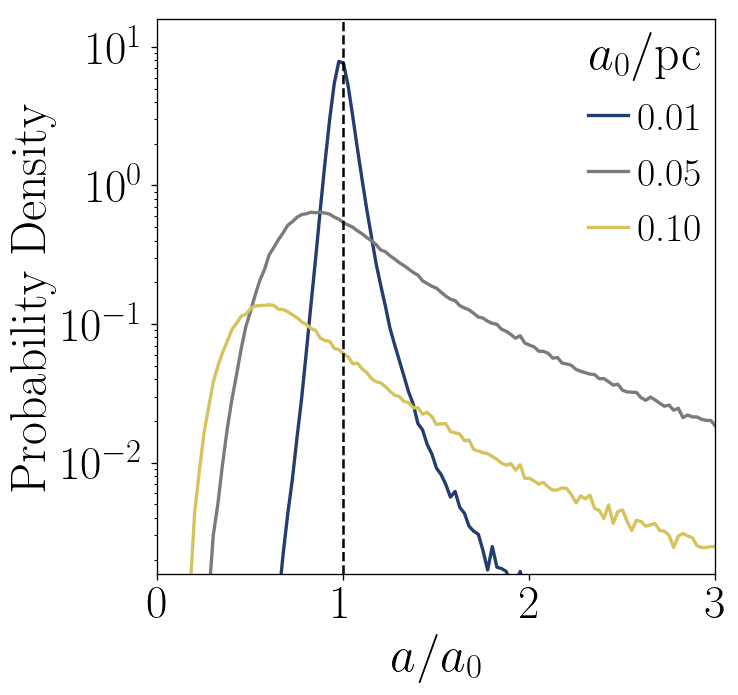

In [10]:
''' 
Figure 8. Scattering matrix for binary

purpose: show how the scattering matrix depends on different semimajor axes

data: data/a_evolution.npy
        
source: farm:\het\p4\ramirez\dmbinaries\shooter_ell\q_pipeline
    for new velocity dispersion: files are labelled with _nv

KEY DIFFERENCE BETWEEN THIS FILE AND UNI_PIPELINE FILES: 
    makejob.py and makejob_sort.py
    
         modified to run multiple simulations for binaries with the same orbital parameters
         I.e., use a for loop in range(N_runs) to run N_runs simulations of binaries in the typical way
     
'''

a0_list = np.flip([0.1, 0.05, 0.01])
e0 = 0.5
psii = 0 
Mp = 1000

N_binaries = int(10**6)
results_list = np.load('data/a_evolution_nv.npy', allow_pickle = True)

# ---

fig_a = plt.figure(figsize=(6,6), dpi= 120)
ax = fig_a.add_subplot(111)

cmaps = ['cividis_r']
color_codes = np.array([0.85, 0.5, 0.15])

cmap = plt.get_cmap(cmaps[0])
colors = cmap(color_codes)

sf = np.zeros(3)
Nlist = len(results_list)
a_eff_bins = np.arange(0,10,0.025)

for k in range(Nlist):  
    a0 = a0_list[k]
    results_sample = results_list[-1 - k]
    a_sample = results_sample[0]
    n, bins = np.histogram(a_sample / a0_list[k], 
                          np.concatenate((a_eff_bins, [np.PINF])), density = False)
    p = n / np.diff(bins) / N_binaries
    sf[k] = np.sum(n[:-1])/N_binaries
    #ax.step(bins[:-1],p,alpha=1, c = colors[k], lw = 2, where = 'post', label = str.format('{0:.2f}',a0))
    ax.plot(bins[:-1],p,alpha=1, c = colors[k], lw = 2, label = str.format('{0:.2f}',a0))
    # ax.step(bins[:-1],n,alpha=1, c = colors[k], lw = 2, where = 'post', label = str.format('{0:.2f}',a0)) # for y-axis = number of binaries 
ax.set_xlim([0,3])
ax.set_ylim([10**-2.8,10**1.2])
# ax.set_ylim([10**1.5,10**5.5]) # for y-axis = number of binaries 
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlabel('$a/a_{0}$',fontsize=fontsize)
ax.set_ylabel('Probability Density',fontsize=fontsize)

ax.tick_params(axis='both',labelsize=28)
#x0,x1 = ax.get_xlim()
#y0,y1 = ax.get_ylim()
#ax.set_aspect((x1-x0)/(y1-y0))
#ax.set_ylim([y0,np.max(data_mat[i,j,:,:][data_mat[i,j,:,:] < np.inf])])
#ax.axvline(vlines[0,0,k], color = colors[k], lw = 1)
#ax.axhline(y = 10**6, color = 'k', lw = 1, ls = '--')

legend = ax.legend(title = "$a_{0}/{\\rm pc}$", ncol=1, frameon = False, handletextpad=0.25, fontsize=24,
                 borderpad=0.5, handlelength = 1, loc='best', bbox_to_anchor=(0.7, 0.55, 0, 0.5))

ax.axvline(x = 1, ls = '--', c = 'k', lw = 1.5)

fig_a.savefig('figures/fig-a-evol-v0.8.pdf', format = 'pdf', bbox_inches='tight')

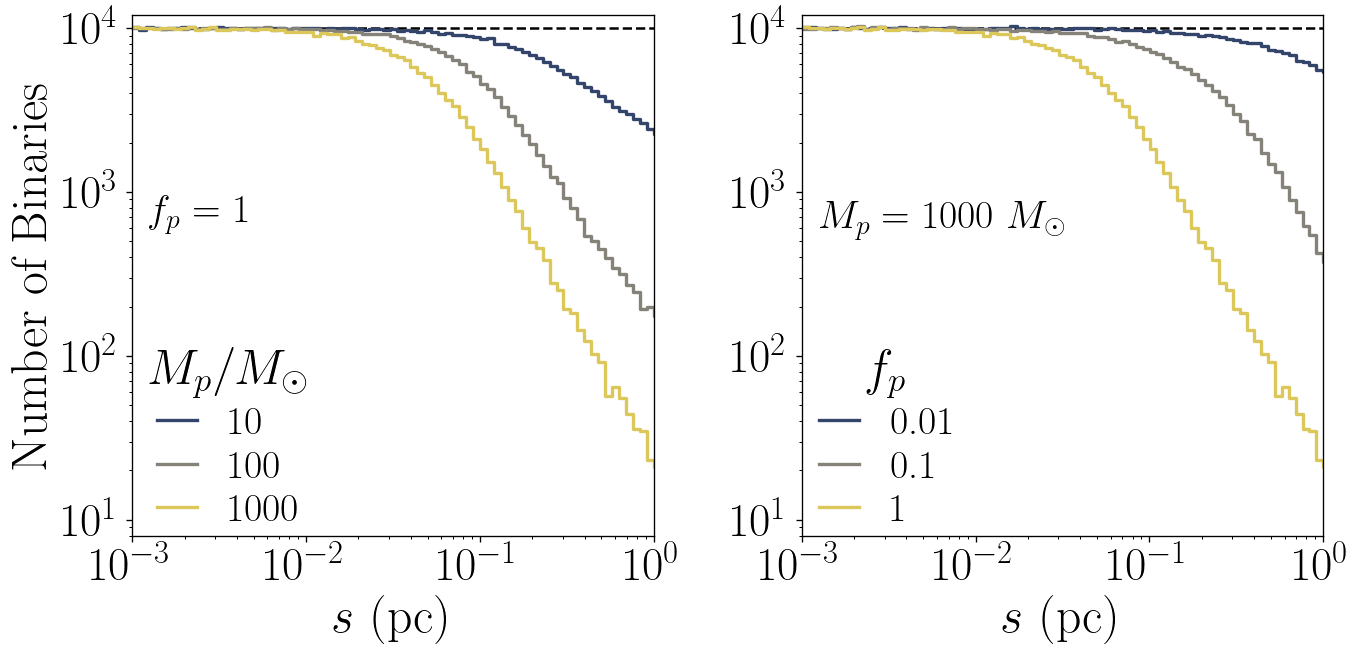

In [11]:
# ''' 
# Figure 9. Evolved flat separation distributions

# purpose: show how evolved semimajor axis distribution depends on Mp and fp

# data: data/sep_dist_flat.npy
        
# source: farm:\het\p4\ramirez\dmbinaries\shooter_edr3\uni_pipeline\sep_dist\macho_figures_v0.5.ipynb
     
# '''

# plt.rcParams['axes.labelsize'] = 30 
# plt.rcParams['axes.titlesize'] = 30 
# plt.rcParams['font.size'] = 30 
# plt.rcParams['lines.linewidth'] = 2 
# plt.rcParams['lines.markersize'] = 8 
# plt.rcParams['legend.fontsize'] = 28 

results_list = np.load('data/sep_dist_flat_nv.npy', allow_pickle = True)
m_list, T_list, f_list = results_list[0]
mid_hist = results_list[1]
n_Mp_list, n_T_list, n_fp_list = results_list[2]

# ---

fig_flat = plt.figure(figsize=(12, 6.1), dpi= 120)

ax = fig_flat.add_subplot(121)

cmap = plt.get_cmap('cividis')
color_code = 0.99/5
n_plots = 3

#ax.plot([],[], ls = ' ', label = '$T = 10 \ Gyr$')
#ax.plot([],[], ls = ' ', label = '$f_{p} = 1$')
ax.axhline(y = 10**4, c = 'k', lw = 1.5, ls = '--')
for n in range(len(m_list)):
    m = m_list[n]
    
    color = cmap(color_code)
    
    ax.step(mid_hist,n_Mp_list[n],alpha=1, c = color, label = str(int(m)), lw = 2, where = 'mid')
#     ax.step(mid_hist,n_Mp_list[n],alpha=1, c = color, label = str(int(m)))
    #ax.plot(mid_hist, n_list[n], c = color, alpha = 0.9, ls = ' ', label = '$\\log M_{p}/M_{\\odot} =$ '+ str_log_m_plot, marker = 'step', markersize = 3)
    #ax.errorbar(mid_hist, n_list[n], np.array(err_list[n]), c = color, alpha = 0.9, ls = ' ', label = '$\\log M_{p}/M_{\\odot} =$ '+ str_log_m_plot, marker = 'o', markersize = 2)
    
    color_code += 1/n_plots
    color = cmap(color_code)
    
ax.set_xlabel('$s$ (pc)',fontsize=fontsize)
ax.set_ylabel('Number of Binaries',fontsize=fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_title('$(T/Gyr,f_{p}) = (10, 1)$:')
#ax.set_xlim([0.000245218616272841,1])
#ax.set_ylim([0.001,np.max(n) * 10])
#ax.set_title('Evolved Binaries')

lgnd = ax.legend(fontsize = 24, frameon = False, bbox_to_anchor=(-0.025, -0.045),  title = '$M_{p}/M_{\odot}$',
                borderpad=0.25, handlelength = 1, labelspacing = 0.2, loc = 'lower left')

lgnd._legend_box.align = 'center'

#ax.axvline(x = a0, lw = 0.8)

ax.set_xlim([10**-3,1])
ax.set_ylim([8,12000])

#locmin_y = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)
#ax.yaxis.set_minor_locator(locmin_y)
#ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
#ax.set_yticks(np.logspace(1,4,4))

ax.tick_params(axis='both', labelsize=28)

#ax.text(1.25e-3, 1e3, '$R_{p} = 0.1 \ {\\rm pc}$', style='normal', fontsize = 28)
ax.text(1.25e-3, 6.5e2, '$f_{p} = 1$', style='normal', fontsize = 24)

# ----------------------------------

ax = fig_flat.add_subplot(122)

cmap = plt.get_cmap('cividis')
color_code = 0.99/5

ax.axhline(y = 10**4, c = 'k', lw = 1.5, ls = '--')

for n in range(len(f_list)): 
    f = f_list[n]
    
    color = cmap(color_code)
    
    if f == 1:
        ax.step(mid_hist,n_fp_list[n],alpha=1, c = color, label = str(int(f)), lw = 2, where = 'mid')
#         ax.step(mid_hist,n_fp_list[n],alpha=1, c = color, label = str(int(f)), where = 'mid')
    else:
        ax.step(mid_hist,n_fp_list[n],alpha=1, c = color, label = str(f), lw = 2, where = 'mid')
#         ax.step(mid_hist,n_fp_list[n],alpha=1, c = color, label = str(f), where = 'mid')
    #ax.errorbar(mid_hist, n_list[n], np.array(err_list[n]), c = color, alpha = 0.9, ls = ' ', label = '$f = $ '+ str(f), marker = 'o', markersize = 2)
    
    color_code += 1/3
    color = cmap(color_code)


ax.set_xlabel('$s$ (pc)',fontsize=fontsize)
#ax.set_ylabel('Number of Binaries')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim([0.000245218616272841,1])
#ax.set_ylim([0.001,np.max(n) * 10])
#ax.axhline(y = 10**3, c = 'k', lw = 0.5)

lgnd = ax.legend(fontsize = 24, frameon = False, bbox_to_anchor=(-0.025, -0.045),  title = '$f_{p}$',
                borderpad=0.25, handlelength = 1, labelspacing = 0.2, loc = 'lower left')

lgnd._legend_box.align = 'center'

#ax.axvline(x = a0, lw = 0.8)

ax.set_xlim([10**-3,1])
ax.set_ylim([8,12000])
ax.tick_params(axis='both',labelsize=28)

#locmin_y = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)
#ax.yaxis.set_minor_locator(locmin_y)
#ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
#ax.set_yticks(np.logspace(1,4,4))

#locmin_y = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)
#ax.yaxis.set_minor_locator(locmin_y)
#ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
#ax.set_yticks(np.logspace(1,4,4))

#ax.tick_params(
#    axis='y',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    labelleft=False) # labels along the bottom edge are off

#ax.text(1.25e-3, 1e3, '$R_{p} = 0.1 \ {\\rm pc}$', style='normal', fontsize = 28)
ax.text(1.25e-3, 6e2, '$M_{p} = 1000 \ M_{\\odot}$', style='normal', fontsize = 24)

#fig_flat.tight_layout(pad = 0.05)


#ax.text(-2.6, 400, '(B)', style='normal', fontsize = 22)
#ax.text(-0.2, 400, '(C)', style='normal', fontsize = 22)

fig_flat.tight_layout(pad = 1)
fig_flat.savefig('figures/fig-flat-extended-no-time-v0.8.pdf', format = 'pdf', bbox_inches='tight')

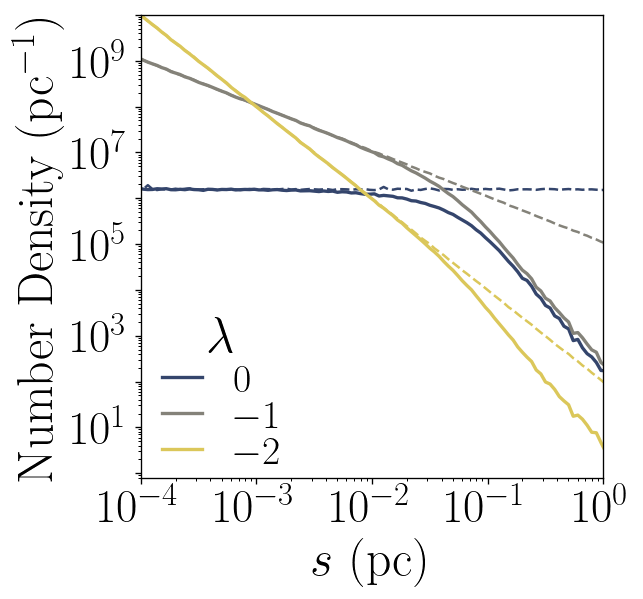

In [12]:
# ''' 
# Figure 10. Evolved power law separation distributions

# purpose: show how we can evolve power law separation distributions

# data: data/sep_dist_power.npy
        
# source: farm:\het\p4\ramirez\dmbinaries\shooter_edr3\uni_pipeline\sep_dist\macho_figures_v0.5.ipynb
     
# '''

# plt.rcParams['axes.labelsize'] = 30 
# plt.rcParams['axes.titlesize'] = 30 
# plt.rcParams['font.size'] = 30 
# plt.rcParams['lines.linewidth'] = 2 
# plt.rcParams['lines.markersize'] = 8 
# plt.rcParams['legend.fontsize'] = 28 

results_list = np.load('data/sep_dist_power_nv.npy', allow_pickle = True)
l_list = results_list[0]
mid, delta_a = results_list[1]
dnda0_list, dnda_list = results_list[2]

# ---

fig_power = plt.figure(figsize=(6, 5.6), dpi= 120)
ax = fig_power.add_subplot(111)

cmap = plt.get_cmap('cividis')
color_code = 0.99/5

#print(len(dnda0_list[n]))
label_string = [str(l_list[0]), '$-$' + str(l_list[1]), '$-$' + str(l_list[2])]
for n in range(len(l_list)): 
    l = l_list[n]
    color = cmap(color_code)
    
    ax.plot(mid, dnda0_list[n], alpha=1, c = color, lw = 1.5, ls = '--')#, where = 'mid')
    ax.plot(mid, dnda_list[n], alpha=1, c = color,lw = 2,ls='-',label = label_string[n])#, label = '$\\lambda =$ '+ str(l), 
    #ax.step(mid, dnda_list[n] * delta_a, alpha=1, c = color, label = '$\\lambda =$ '+ str(l), lw = 2)
    # ax.plot(mid, dnda_list[n] * delta_a, c = color, alpha = 1, ls = ' ', marker = '.', label = '$\\lambda =$ '+ str(l))
    #ax.errorbar(mid_hist, (dnda_list[n] * delta_a), np.array(dnda_err_list[n]), c = color, alpha = 0.9, ls = ' ', label = '$\\lambda =$ '+ str(l), marker = 'o', markersize = 2)
    
    color_code += 1/3
    color = cmap(color_code)
    
ax.set_xlabel('$s$ (pc)',fontsize=fontsize)
ax.set_ylabel('Number Density (pc$^{-1}$)',fontsize=fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim([0.000245218616272841,1])
#ax.set_ylim([0.001,np.max(n) * 10])
#ax.axhline(y = 10**3, c = 'k', lw = 0.5)
        
#ax.axvline(x = a0, lw = 0.8)

ax.set_xlim([10**-4,10**0])
ax.set_ylim([0.8,10**10])

locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)
ax.xaxis.set_minor_locator(locmin_x)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax.set_xticks(np.logspace(-4,0,5))

locmin_y = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)
ax.yaxis.set_minor_locator(locmin_y)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax.set_yticks(np.logspace(1,5,3))

# This allows us to manually modify tick labels
ax.set_yticks(np.logspace(0,10,11))
plt.draw()

# labels = [item.get_text() for item in ax.get_xticklabels()]
# for n in range(1,len(labels),2): labels[n] = ' ' 
    
# ax.set_xticklabels(labels)

labels = [item.get_text() for item in ax.get_yticklabels()]
for n in range(0,len(labels),2): labels[n] = ' ' 
    
ax.set_yticklabels(labels)
ax.tick_params(axis='both',labelsize=28)
    
color_code = 0.99/5

lgnd = ax.legend(fontsize = 24, frameon = False, bbox_to_anchor=(-0.02, -0.05),  title = '$\lambda$',
                borderpad=0.25, handlelength = 1, labelspacing = 0, loc = 'lower left')

#             lgnd = ax.legend(frameon = False, title = '$f_{p}$', handletextpad=0.5,
#                          borderpad=0.25, handlelength = 1, bbox_to_anchor=(1.05, -0.05), loc='lower right', 
#                             labelspacing = 0.5)
lgnd._legend_box.align = 'center'

fig_power.tight_layout(pad = 1)
fig_power.savefig('figures/fig-power-extended-v0.8.pdf', format = 'pdf', bbox_inches='tight')

AxesSubplot(0.131579,0.684211;0.263158x0.263158)
AxesSubplot(0.407895,0.684211;0.263158x0.263158)
AxesSubplot(0.684211,0.684211;0.263158x0.263158)
AxesSubplot(0.131579,0.407895;0.263158x0.263158)
AxesSubplot(0.407895,0.407895;0.263158x0.263158)
AxesSubplot(0.684211,0.407895;0.263158x0.263158)
AxesSubplot(0.131579,0.131579;0.263158x0.263158)
AxesSubplot(0.407895,0.131579;0.263158x0.263158)
AxesSubplot(0.684211,0.131579;0.263158x0.263158)
$-1.587_{-0.036}^{+0.037}$
$-0.729_{-0.089}^{+0.103}$
$0.243_{-0.044}^{+0.050}$


<Figure size 720x720 with 0 Axes>

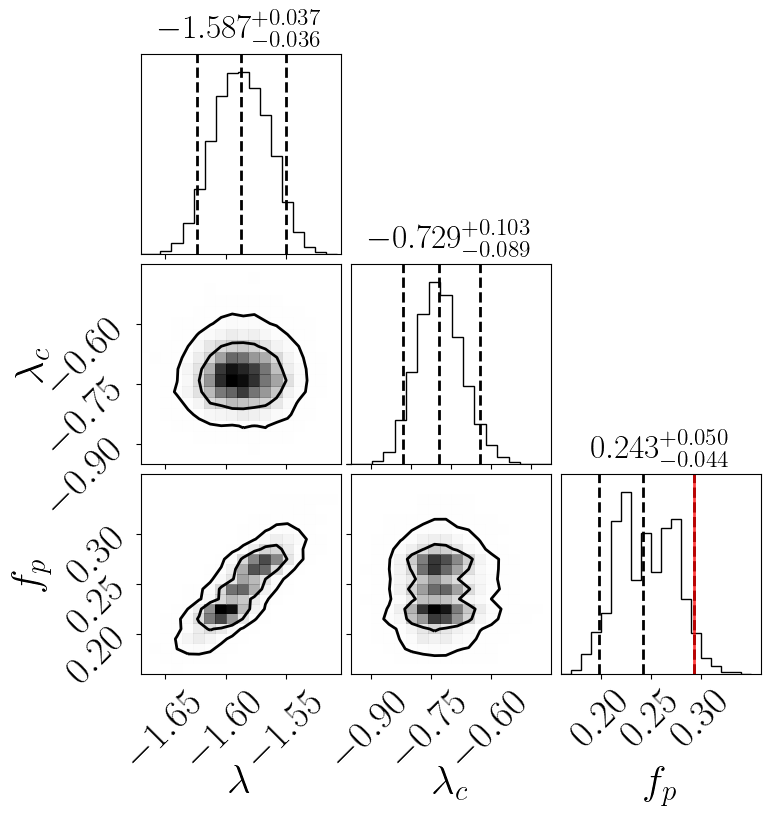

In [13]:
# ''' 
# Figure 11. Sampled posterior

# purpose: show how the posterior appears for the model parameters and the perturber population

# data: data/single_constraint.npy
        
# source: farm:\het\p4\ramirez\dmbinaries\shooter_edr3\uni_pipeline\sep_dist
#         \emcee_data\-1.000_0.000_0.200_-2.00_4.00_log_-5.000_2.000_0.04_0.000_0.000_200_200_600\
#         5.000_2.000_0.04_0.000_0.000_200_200_600.npy
     
# '''

results_list = np.load('data/single_constraint_nv.npy', allow_pickle = True)

emcee_res = results_list[0]
flatchain = emcee_res[0]
flatchain[:,0] = -flatchain[:,0]
flatchain[:,1] = -flatchain[:,1]
flatchain[:,-1] = 10**flatchain[:,-1]
catalog_data = results_list[1]

# ---

import corner

fig_corner = plt.figure(figsize=(6,6), dpi= 120)

cmap = plt.get_cmap('cividis')
color_code = 0.99/5
color_code += 2/3
color = cmap(color_code)

# plot the constraints
label_names = [r'$\lambda$', r'$\lambda_{c}$', r'$f_{p}$'] 
figure = corner.corner(flatchain, labels = label_names, quantiles=[0.05, 0.5, 0.95], 
                  levels = (0.68, 0.95), title_kwargs={"fontsize": 18}, 
                  plot_datapoints = False, plot_density = True, color = 'black', linewidth = 2,
                 bins = 19, label_kwargs={"fontsize": 30}, tick_kwargs={"fontsize": 30}, labelpad = 0.15)

for ax in figure.get_axes():
    print(ax)
    
    if str(ax) == "AxesSubplot(0.131579,0.684211;0.263158x0.263158)":
        ax.set_xlim([-1.67,-1.505])
        ax.set_xticks(- np.array([1.55,1.60,1.65] ))
        ax.tick_params(axis='both',labelsize=28)
    
    if str(ax) == "AxesSubplot(0.131579,0.407895;0.263158x0.263158)":
        ax.set_xlim([-1.67,-1.505])
        ax.set_xticks(- np.array([1.55,1.60,1.65] ))
        ax.set_yticks(- np.array([0.60, 0.75, 0.90]))
        ax.set_ylim([-0.95,-0.45])
        ax.tick_params(axis='both',labelsize=28)
        
    if str(ax) == "AxesSubplot(0.131579,0.131579;0.263158x0.263158)":
        ax.set_xlim([-1.67,-1.505])
        ax.set_xticks(- np.array([1.55,1.60,1.65] ))
        
        ax.set_yticks([0.20, 0.25, 0.30])
        ax.set_ylim([0.16,0.36])
        ax.tick_params(axis='both',labelsize=28)
    
    if str(ax) == "AxesSubplot(0.407895,0.407895;0.263158x0.263158)":
        ax.set_yticks(- np.array([0.60, 0.75, 0.90]))
        
        ax.set_xlim([-0.95,-0.45])
        ax.tick_params(axis='both',labelsize=28)
    
    if str(ax) == "AxesSubplot(0.407895,0.131579;0.263158x0.263158)":
        ax.set_yticks(- np.array([0.60, 0.75, 0.90]))
        ax.set_ylim([-0.95,-0.45])
        ax.tick_params(axis='both',labelsize=28)
        
    if str(ax) == "AxesSubplot(0.407895,0.131579;0.263158x0.263158)":
        ax.set_yticks([0.20, 0.25, 0.30])
        ax.set_ylim([0.16,0.36])
        ax.set_xlim([-0.95,-0.45])
        ax.set_xticks(- np.array([0.60, 0.75, 0.90]))
        ax.tick_params(axis='both',labelsize=28)
    
    if str(ax) == "AxesSubplot(0.684211,0.131579;0.263158x0.263158)":
        ax.set_xticks([0.20, 0.25, 0.30])
        ax.set_xlim([0.16,0.36])
        ax.tick_params(axis='both',labelsize=28)

# Add line on limit

axes = np.array(figure.axes).reshape((3, 3))
labels = ['\lambda', '\lambda_{c}', 'f_{p}'] 
for i in range(3):
    ax = axes[i, i]
    mcmc = np.percentile(flatchain[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "${0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    print(txt)
    ax.set_title(txt, pad = 12, fontsize = 24)
    
ax = axes[2, 2]
ax.axvline(x = mcmc[1] + q[1], color="r", lw = 2, alpha = 0.75)


#     if str(ax) == "AxesSubplot(0.181818,0.181818;0.363636x0.363636)":
#         ax.set_xlim([1.45,1.64])
#         ax.set_xticks([1.45,1.50,1.55, 1.60])
        
#         ax.set_ylim([0.1,0.32])
#         ax.set_yticks([0.15,0.2,0.25, 0.3])

#     if str(ax) == "AxesSubplot(0.563636,0.181818;0.363636x0.363636)": 
#         ax.set_xlim([0.1,0.32])
#         ax.set_xticks([0.15,0.2,0.25, 0.3])
        
#     if str(ax) == "AxesSubplot(0.181818,0.563636;0.363636x0.363636)":
#         ax.set_xlim([1.45,1.64])
#         ax.set_xticks([1.45,1.50,1.55, 1.60])
        
#     if str(ax) == "AxesSubplot(0.563636,0.563636;0.363636x0.363636)":
#         ax.set_xlim([1.45,1.64])
#         #ax.set_xticks([0.15,0.2,0.25, 0.3])

#figure.savefig('fig-pm-corner.svg', format = 'svg', bbox_inches='tight', dpi = 120)
figure.savefig('figures/fig-corner-v0.8.pdf', format = 'pdf', bbox_inches='tight', dpi = 120)

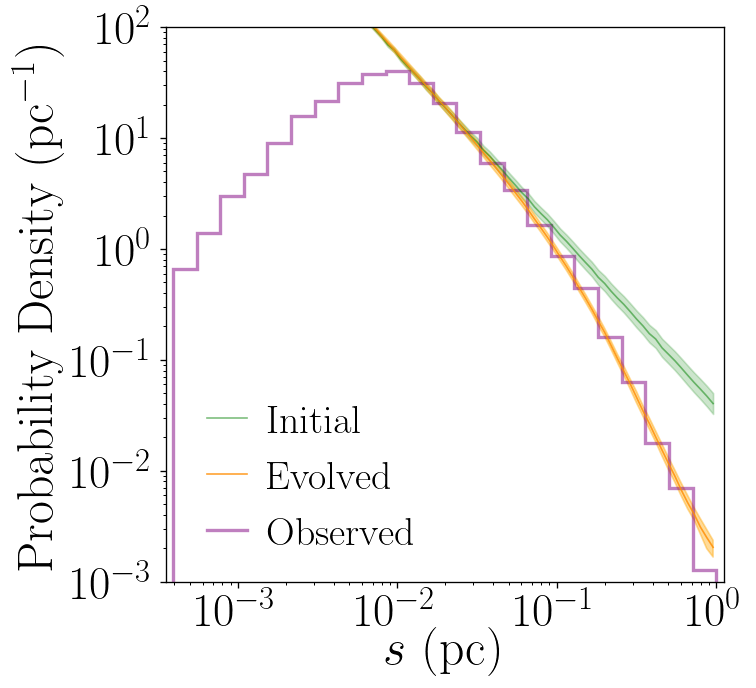

In [14]:
# ''' 
# Figure 12. Best-fit separation distributions with 95% boundaries

# purpose: show performance of fit with data

# data: data/evol_sampled.npy
        
# source: D:\dmbinaries_local\shooter_edr3\evol_dist_sampler.ipynb
     
# '''
from matplotlib.lines import Line2D
mid_data, phi_vec_contours, phi0_vec_contours = np.load('data/evol_sampled_new_nv.npy', allow_pickle = True)
phi_vec_5, phi_vec_50, phi_vec_95 = phi_vec_contours
phi0_vec_5, phi0_vec_50, phi0_vec_95 = phi0_vec_contours

# plot distributions with free parameters sampled from posterior
fig = plt.figure(figsize=(6,6), dpi= 120)
ax = fig.add_subplot(111)

counts, bins, _ = ax.hist((cdf_halo['sep_pc']) , bins = np.logspace(-4,0,28), color = 'purple', alpha = 0.5, lw = 2, histtype = 'step'
                          , density = True, label = 'Observed', weights = (1 - cdf_halo['R_chance_align']))
mid_hist = 0.5 * (bins[:-1] + bins[1:])
# ax.scatter(mid_hist[14:], counts[14:], marker = '.', s = 50, color = 'purple')

# ---------------------------------------
from scipy.interpolate import interp1d
interp_phi_50_ = interp1d(mid_data, phi_vec_50)

def offset_(A):
    return  np.sum((A * interp_phi_50_(mid_hist[14:]) - counts[14:])**2)

from scipy.optimize import minimize
res = minimize(lambda A: offset_(A),[5],
                        method = 'Nelder-Mead', 
                        options={'maxiter':1000,'maxfev':1000,'adaptive':True,'xatol':0.0001,'fatol':0.0001})

offset = res.x
# ---------------------------------------
ax.plot(mid_data, offset*phi0_vec_50, lw = 1, ls = '-', alpha=0.5, c='green', label = 'Initial')
ax.plot(mid_data, offset*phi_vec_50, lw = 1, ls = '-', alpha=0.8, c='darkorange', label = 'Evolved')

ax.fill_between(mid_data, offset*phi0_vec_5, offset*phi0_vec_95, color = 'green', alpha=0.2)
ax.fill_between(mid_data, offset*phi_vec_5, offset*phi_vec_95, color = 'orange', alpha=0.4)
                
ax.set_xlabel('$s \ (\\rm{pc})$', labelpad = -5,fontsize=fontsize)
ax.set_ylabel('Probability Density $({\\rm pc^{-1}})$',fontsize=fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**-3.45,10**0.05])
ax.set_ylim([10**-3,10**2])

handles, labels = ax.get_legend_handles_labels()

new_handles = handles
# new_handles[0] = handles[0]
# new_handles[1] = handles[0]
# new_handles[2] = handles[1]
new_handles[-1] = Line2D([], [], c='purple', alpha = 0.5)

# new_labels = labels
# new_labels[0] = labels[-1]
# new_labels[1] = labels[0]
# new_labels[2] = labels[1]
#new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

lgnd = ax.legend(handles=new_handles,labels=labels,frameon = False, handletextpad=0.5,
             borderpad=0.25, handlelength = 1, bbox_to_anchor=(0.5, 0), loc='lower right', 
                labelspacing = 0.5, fontsize = 24)
lgnd._legend_box.align = 'right'

ax.tick_params(axis='both',which='both',labelsize=28)
ax.xaxis.set_major_locator(mpl.ticker.LogLocator(numticks=999))
ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(numticks=999, subs="auto"))

ax.yaxis.set_major_locator(mpl.ticker.LogLocator(numticks=999))
ax.yaxis.set_minor_locator(mpl.ticker.LogLocator(numticks=999, subs="auto"))
plt.show()

fig.savefig('figures/fig-evol-sampled-new-v0.8.pdf', format = 'pdf', bbox_inches='tight', dpi = 120)

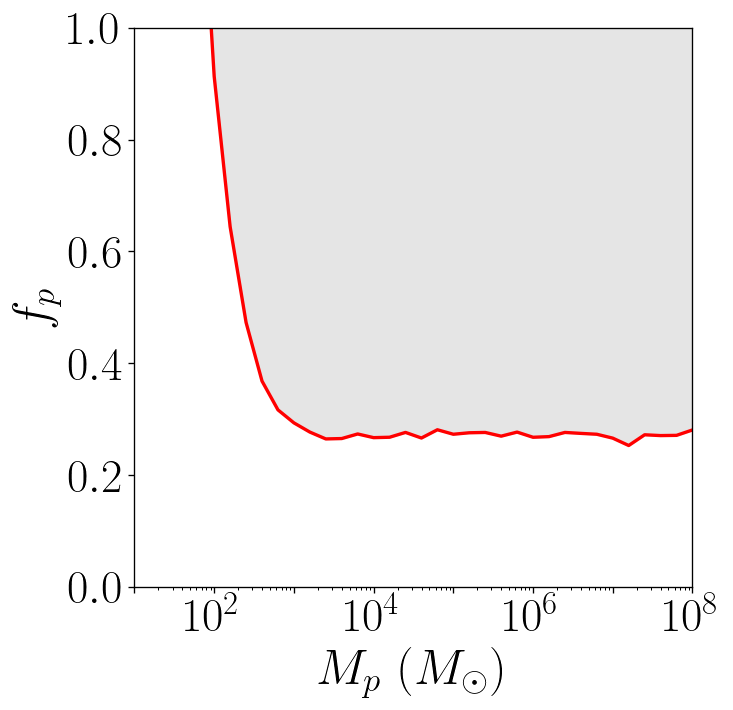

In [15]:
# ''' 
# Figure 13. Constraints versus perturber mass

# purpose: show how limits in fp depends on Mp

# data: data/constraints_uni_v_Mp.npy
        
# source: farm:\het\p4\ramirez\dmbinaries\shooter_edr3\uni_pipeline\sep_dist\emcee_plotter_v0.3.ipynb
     
# '''

log_mlist, log_f_2sigma = np.load('data/constraints_uni_v_Mp_nv.npy', allow_pickle = True)

fig_c_Mp = plt.figure(figsize=(6,6.05), dpi= 120)
ax = fig_c_Mp.add_subplot(111)

ax.plot(10**log_mlist,10**log_f_2sigma, color = 'red', alpha = 1, label = '$95 \ \%$')

ax.fill_between(10**log_mlist, 1.1,10**log_f_2sigma, color='gray', alpha=0.2)

ax.set_xlabel('$M_{p} \ (M_{\odot})$',fontsize=fontsize)
ax.set_ylabel('$f_{p}$',fontsize=fontsize)

ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlim([10**1, 10**8])
ax.set_ylim([0,10**0])

locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)
ax.xaxis.set_minor_locator(locmin_x)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# This allows us to manually modify tick labels
ax.set_xticks(np.logspace(1,8,8))
plt.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
for n in range(0,len(labels),2): labels[n] = ' ' 

ax.tick_params(axis='both',labelsize=28)
ax.set_xticklabels(labels,fontsize=28)

fig_c_Mp.savefig('figures/fig-constraints-mass-v0.8.pdf', format = 'pdf', bbox_inches='tight', dpi = 120)

In [16]:
# ''' 
# Figure 14. Constraints versus perturbers and radius

# purpose: show how limits in fp depends on Mp and Rp

# data: 1. data/fp_vs_Mp_plots.npy
#       2. data/fp_vs_rs_plots.npy
#       3. data/contour_plotter.npy
        
# source: 1. data/fp_vs_Mp_or_rs.ipynb 
#                 - requires all the emcee_data file for plaw perturbers to be in 
#                     data/eDR3_plaws/emcee_data
#          2. data/fp_vs_Mp_or_rs.ipynb 
#                 - requires all the emcee_data file for plaw perturbers to be in 
#                     data/eDR3_plaws/emcee_data
#         3. farm:/dmbinaries/shooter_edr3/newgen_pipeline/sep_dist/contour_plotter.ipynb
# '''

## halo fraction
log_f = 0.2 # halo fraction [setting max number of time steps]
f = 10**log_f
str_log_f = str.format('{0:.3f}',log_f)

# threshold fractional energy injection defining p_max
log_eps = -2.00
energy_fraction = 10**log_eps
str_log_eps = str.format('{0:.2f}',log_eps)

# ------------------------
## approximate number of encounters
log_K = np.log10(5000)
str_log_K = str.format('{0:.2f}',log_K)
# ------------------------
## list of a0-values
bin_scale = 'log'

log_alow = -5
str_log_alow = str.format('{0:.3f}',log_alow)
log_ahigh = 2
str_log_ahigh = str.format('{0:.3f}',log_ahigh)
step_size = 0.04 # number of bins
str_step_size = str(step_size)
#str_step_size = str.format('{0:.3f}',step_size)

log_alow_offset = 0
str_log_alow_offset = str.format('{0:.3f}',log_alow_offset)
log_ahigh_offset = 0
str_log_ahigh_offset = str.format('{0:.3f}',log_ahigh_offset)

# ------------------------
## emcee parameters
nwalkers = int(200)
str_nwalkers = str(nwalkers)

burn = int(200)
str_burn = str(burn)

n_steps = int(600)
str_n_steps = str(n_steps)

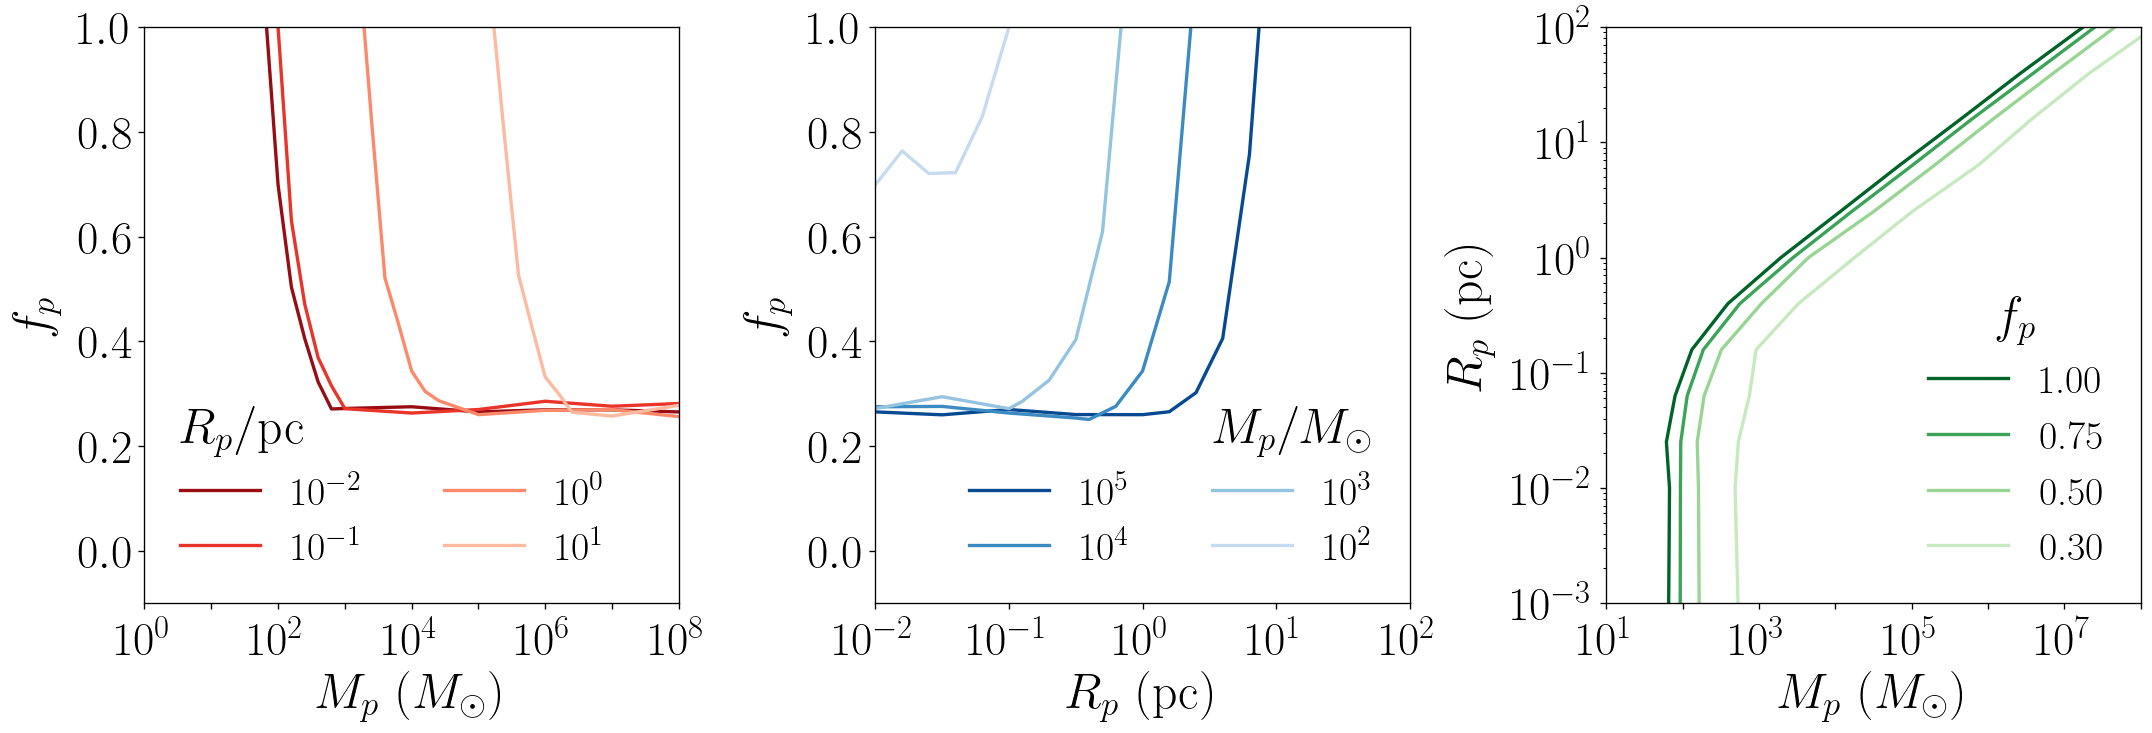

In [17]:
# plt.rcParams['axes.labelsize'] = 30 * 3 / 2
# plt.rcParams['axes.titlesize'] = 28 * 3 / 2
# plt.rcParams['legend.title_fontsize'] = 28 * 3 / 2
# plt.rcParams['font.size'] = 30  * 3 / 2
# plt.rcParams['lines.linewidth'] = 2 * 3 / 2
# plt.rcParams['lines.markersize'] = 8 * 3 / 2
# plt.rcParams['legend.fontsize'] = 28 * 3 / 2

fig = plt.figure(figsize=(18,6), dpi= 120)

# ======================
# ======================
log_rslist = [-2,-1,0,1]
alpha_list = [0]

results_list_fp_vs_Mp = np.load('data/fp_vs_Mp_plots_nv.npy', allow_pickle = True)

Na = len(alpha_list)
for na in range(Na):
    alpha = alpha_list[na]
    str_alpha = str.format('{0:.3f}',alpha)
    
    ax = plt.subplot2grid((1,3),(na,0))
    
    cmap = plt.get_cmap('Reds')
    color_codes = [0.9, 0.65, 0.4, 0.25]
    ncolor = 0
    
    results_list_fp_vs_Mp_alpha = results_list_fp_vs_Mp[na]
    log_mlist_list, log_fp_list = results_list_fp_vs_Mp_alpha
    
    for nrs in range(len(log_rslist)):
        color_code = color_codes[ncolor]
        color = cmap(color_code)
        ncolor += 1
        
        log_rs = log_rslist[nrs]
        str_log_rs = str.format('{0:.3f}',log_rs)
        
        log_mlist = log_mlist_list[nrs]
        log_f_2sigma = log_fp_list[nrs]
        
        if log_rs < 0:
            str_log_rs = '$-$' + str.format('{0:.2f}',-log_rs)
        else:
            str_log_rs = str.format('{0:.2f}',log_rs)
        ax.plot(10**log_mlist,10**log_f_2sigma, alpha = 1, label = r'$10^{%i}$'%int(float(log_rs)), color = color)
        
        ax.set_ylabel('$f_{p}$', labelpad = 10, fontsize = fontsize)
        #ax.set_title('MACHO Constraints')


        ax.set_xscale('log')
        ax.set_yscale('linear')
        ax.set_xlim([10**0, 10**8])
        ax.set_ylim([-0.1,1])
        
        locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)

        # This allows us to manually modify tick labels
        ax.set_xticks(np.logspace(0,8,9))
        plt.draw()

        labels = [item.get_text() for item in ax.get_xticklabels()]
        for n in range(1,len(labels),2): labels[n] = ' ' 

        ax.set_xticklabels(labels)
        ax.tick_params(axis='both',labelsize=28)
        ax.tick_params(axis='x', pad=7.5)  
        
        ax.set_xlabel('$M_{p} \ (M_{\odot})$', fontsize = fontsize)
        lgnd = ax.legend(frameon = False,ncol=2,title=r'$R_p/{\rm pc}$',
                         fontsize=24,loc='lower left')
        lgnd._legend_box.align = 'left'
        lgnd.get_title().set_fontsize(30)
        
#         lgnd = ax.legend(frameon = False, title = '$\\log R / { \\rm pc}$', ncol = 2, handletextpad=0.5,
#                      borderpad=0.25, handlelength = 1, bbox_to_anchor=(1.075, 0.5), loc='lower right', 
#                  columnspacing = 1, labelspacing = 0.1)
#         lgnd._legend_box.align = 'right'
        
# ======================
# ======================

log_mlist = [5,4,3,2]
alpha_list = [0]

results_list_fp_vs_rs = np.load('data/fp_vs_rs_plots_nv.npy', allow_pickle = True)

Na = len(alpha_list)
for na in range(Na):
    alpha = alpha_list[na]
    str_alpha = str.format('{0:.3f}',alpha)
    
    ax = plt.subplot2grid((1,3),(na,1))
    
    cmap = plt.get_cmap('Blues')
    color_codes = [0.9, 0.65, 0.4, 0.25]
    ncolor = 0
    
    results_list_fp_vs_rs_alpha = results_list_fp_vs_rs[na]
    log_rslist_list, log_fp_list = results_list_fp_vs_rs_alpha
    
    for nm in range(len(log_mlist)):
        color_code = color_codes[ncolor]
        color = cmap(color_code)
        ncolor += 1
        
        log_rslist = log_rslist_list[nm]
        log_f_2sigma = log_fp_list[nm]
        
        log_m = log_mlist[nm]
        str_log_m = str.format('{0:.2f}',log_m)
        ax.plot(10**log_rslist,10**log_f_2sigma, alpha = 1, label = r'$10^%i$'%int(float(log_m)), color = color)
        
        ax.set_ylabel('$f_{p}$', labelpad = 10,fontsize=fontsize)

        ax.set_xscale('log')
        ax.set_yscale('linear')
        ax.set_xlim([10**-2, 10**2])
        ax.set_ylim([-0.1,1])

        locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)

        # This allows us to manually modify tick labels
        ax.set_xticks(np.logspace(-2,2,5))
        plt.draw()

        labels = [item.get_text() for item in ax.get_xticklabels()]
        #for n in range(1,len(labels),2): labels[n] = ' ' 

        ax.set_xticklabels(labels)
        ax.tick_params(axis='both',labelsize=28)
        ax.tick_params(axis='x', pad=7.5)  

        plt.draw()

        ax.set_xlabel('$R_{p} \ ({\\rm pc})$',fontsize=fontsize)

        lgnd = ax.legend(frameon = False,ncol=2,title=r'$M_p/M_\odot$',
                         fontsize=24,loc='lower right')
        lgnd._legend_box.align = 'right'
        lgnd.get_title().set_fontsize(30)
#             lgnd = ax.legend(frameon = False, ncol = 2, title = '$\\log M_{p}/M_{\odot}$', handletextpad=0.5,
#                      borderpad=0.25, handlelength = 1, bbox_to_anchor=(0.75, 0.55), loc='lower right', 
#                      columnspacing = 1, labelspacing = 0.01)
#             lgnd._legend_box.align = 'left'
        #lgnd = ax.legend(ncol=1, frameon = False, handletextpad=0.25, 
         #borderpad=0.25, handlelength = 0.5, loc='best', bbox_to_anchor=(0.5, 0.6, 0, 0.5))
# ======================
# ======================

log_m_crit_mat, log_rslist = np.load('data/eDR3_plaws/contour_plots_nv.npy', allow_pickle = True)

alpha_list = [0]
f_list = [1,0.75,0.5,0.3]

Na = len(alpha_list)
Nf = len(f_list)
for na in range(Na):
    alpha = alpha_list[na]
    ax = plt.subplot2grid((1,3),(na,2))

    cmap = plt.get_cmap('Greens')
    color_codes = [0.9, 0.65, 0.4, 0.25]
    ncolor = 0
    
    for nf in range(Nf):
        f = f_list[nf]
        str_f = str.format('{0:.2f}',f) 
        
        color_code = color_codes[ncolor]
        color = cmap(color_code)
        ncolor += 1

        ax.plot(10.**log_m_crit_mat[na,nf,:], 10.**log_rslist,
                label = str_f, alpha = 1, color = color)
        

        ax.set_ylabel('$R_{p} \ (\\rm{pc})$', labelpad = 10,fontsize=fontsize)
        # ax.set_title('General Constraints')
        ax.set_xlim(10**1,10**8)
        ax.set_ylim(10**-3,10**2)
        ax.set_xscale('log')
        ax.set_yscale('log')
        
        locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)

        # This allows us to manually modify tick labels
        ax.set_xticks(np.logspace(1,8,8))
        plt.draw()

        labels = [item.get_text() for item in ax.get_xticklabels()]
        for n in range(1,len(labels),2): labels[n] = ' ' 

        ax.set_xticklabels(labels)
        ax.tick_params(axis='both',labelsize=28)
        ax.tick_params(axis='x', pad=7.5)  
        
        plt.draw()

        # This allows us to manually modify tick labels
        ax.set_yticks(np.logspace(-3,2,6))
        plt.draw()

        labels = [item.get_text() for item in ax.get_yticklabels()]
        #for n in range(0,len(labels),2): labels[n] = ' ' 

        ax.set_yticklabels(labels)

        ax.set_xlabel('$M_{p} \ (M_{\\odot})$',fontsize=fontsize)
        lgnd = ax.legend(frameon = False, title=r'$f_p$',fontsize=24)
        lgnd._legend_box.align = 'center'
        lgnd.get_title().set_fontsize(30)
        
fig.tight_layout(pad = 0.1)
fig.savefig('figures/fig-constraints-dependence-v0.8.pdf', format = 'pdf', bbox_inches='tight', dpi = 120)

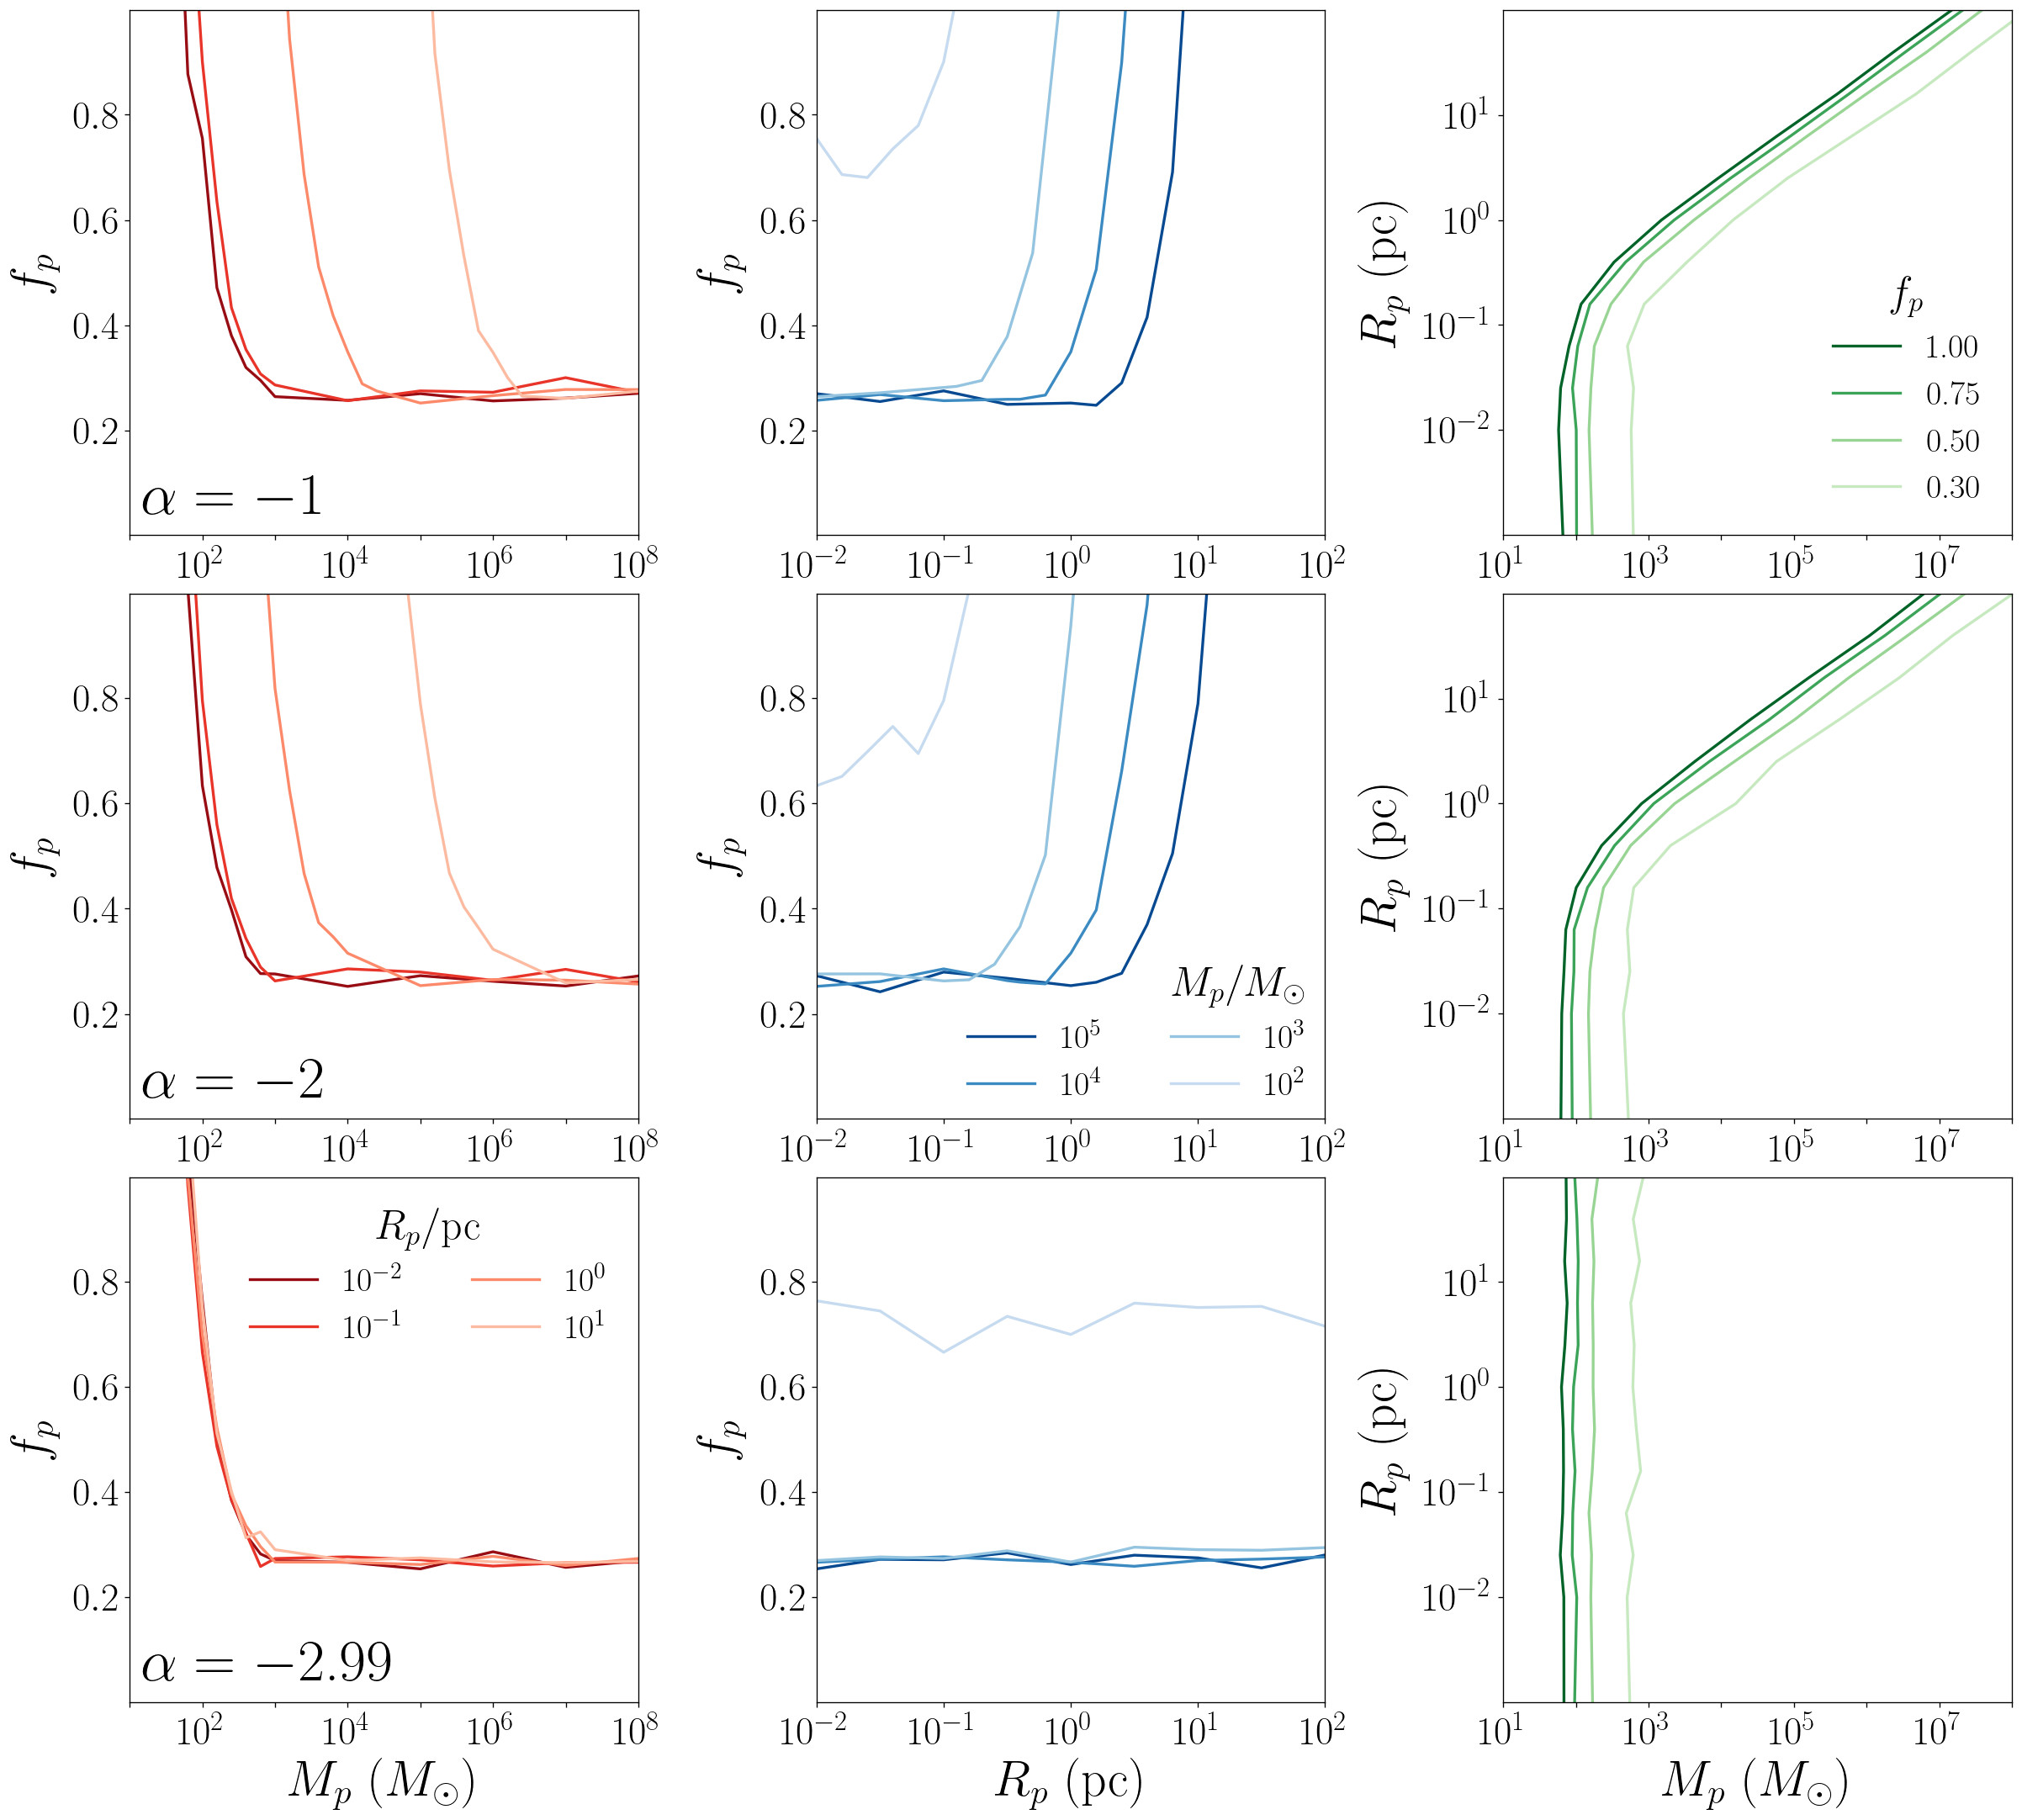

In [18]:
# ''' 
# Figure 15. Constraints versus perturbers and radius for various power-law indices alpha

# purpose: show how limits in fp depends on Mp and Rp and alpha

# data: 1. data/fp_vs_Mp_plots.npy
#       2. data/fp_vs_rs_plots.npy
#       3. data/contour_plotter.npy
        
# source: 1. data/fp_vs_Mp_or_rs.ipynb 
#                 - requires all the emcee_data file for plaw perturbers to be in 
#                     data/eDR3_plaws/emcee_data
#          2. data/fp_vs_Mp_or_rs.ipynb 
#                 - requires all the emcee_data file for plaw perturbers to be in 
#                     data/eDR3_plaws/emcee_data
#         3. farm:/dmbinaries/shooter_edr3/newgen_pipeline/sep_dist/contour_plotter.ipynb
# '''

# plt.rcParams['axes.labelsize'] = 30 * 3 / 2
# plt.rcParams['axes.titlesize'] = 28 * 3 / 2
# plt.rcParams['legend.title_fontsize'] = 28 * 3 / 2
# plt.rcParams['font.size'] = 30  * 3 / 2
# plt.rcParams['lines.linewidth'] = 2 * 3 / 2
# plt.rcParams['lines.markersize'] = 8 * 3 / 2
# plt.rcParams['legend.fontsize'] = 28 * 3 / 2

fig = plt.figure(figsize=(20,18), dpi= 120)

# ======================
# ======================
log_rslist = [-2,-1,0,1]
alpha_list = np.array([-1,-2,-3])

results_list_fp_vs_Mp = np.load('data/fp_vs_Mp_plots_nv.npy', allow_pickle = True)

Na = len(alpha_list)
for na in range(Na):
    alpha = alpha_list[na]
    str_alpha = str.format('{0:.3f}',alpha)
    
    ax = plt.subplot2grid((3,3),(na,0))
    
    cmap = plt.get_cmap('Reds')
    color_codes = [0.9, 0.65, 0.4, 0.25]
    ncolor = 0

    results_list_fp_vs_Mp_alpha = results_list_fp_vs_Mp[na+1]
    log_mlist_list, log_fp_list = results_list_fp_vs_Mp_alpha
    
    for nrs in range(len(log_rslist)):
        color_code = color_codes[ncolor]
        color = cmap(color_code)
        ncolor += 1
        
        log_rs = log_rslist[nrs]
        str_log_rs = str.format('{0:.3f}',log_rs)
        
        log_mlist = log_mlist_list[nrs]
        log_f_2sigma = log_fp_list[nrs]
        
        if log_rs < 0:
            str_log_rs = '$-$' + str.format('{0:.0f}',-log_rs)
        else:
            str_log_rs = str.format('{0:.0f}',log_rs)
        ax.plot(10**log_mlist,10**log_f_2sigma, alpha = 1, label = r'$10^{%i}$'%int(float(log_rs)), color = color)
        
        ax.set_ylabel('$f_{p}$', labelpad = 10,fontsize=fontsize+6)
        #ax.set_title('MACHO Constraints')


        ax.set_xscale('log')
        ax.set_yscale('linear')
        ax.set_xlim([10**1, 10**8])
        ax.set_ylim([0.001,0.999])
        
        locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)

        # This allows us to manually modify tick labels
        ax.set_xticks(np.logspace(1,8,8))
        plt.draw()

        labels = [item.get_text() for item in ax.get_xticklabels()]
        for n in range(0,len(labels),2): labels[n] = ' ' 

        ax.set_xticklabels(labels)
        ax.tick_params(axis='x', pad=7.5)  
        ax.tick_params(axis='both',labelsize=28)
        
    if na == 2:
        ax.set_xlabel('$M_{p} \ (M_{\odot})$',fontsize=fontsize+6)
        lgnd = ax.legend(frameon = False, title = '$R_{p} / { \\rm pc}$', ncol = 2,
                        loc='upper right',fontsize=24)#, handletextpad=0.5,
                    # borderpad=0.25, handlelength = 1, bbox_to_anchor=(1.075, 0.5), loc='lower right', 
                 #columnspacing = 1, labelspacing = 0.1)
        lgnd._legend_box.align = 'center'
        lgnd.get_title().set_fontsize(30)
    
    if na == 2:
        ax.text(15, 4e-2, '$\\alpha = -$' + str(2.99), fontsize = 28 * 3/2)
    else:
        ax.text(15, 4e-2, '$\\alpha = -$' + str(-alpha_list[na]), fontsize = 28 * 3/2)
        
# ======================
# ======================

log_mlist = [5,4,3,2]
alpha_list = [-1,-2,-3]

results_list_fp_vs_rs = np.load('data/fp_vs_rs_plots_nv.npy', allow_pickle = True)

Na = len(alpha_list)
for na in range(Na):
    alpha = alpha_list[na]
    str_alpha = str.format('{0:.3f}',alpha)
    
    ax = plt.subplot2grid((3,3),(na,1))

    cmap = plt.get_cmap('Blues')
    color_codes = [0.9, 0.65, 0.4, 0.25]
    ncolor = 0
    
    results_list_fp_vs_rs_alpha = results_list_fp_vs_rs[na+1]
    log_rslist_list, log_fp_list = results_list_fp_vs_rs_alpha
    
    for nm in range(len(log_mlist)):
        color_code = color_codes[ncolor]
        color = cmap(color_code)
        ncolor += 1
        
        log_rslist = log_rslist_list[nm]
        log_f_2sigma = log_fp_list[nm]
        
        log_m = log_mlist[nm]
        str_log_m = str.format('{0:.2f}',log_m)
        #[4,3,2,1]

        str_log_m = str.format('{0:.0f}',log_m)
        ax.plot(10**log_rslist,10**log_f_2sigma, alpha = 1, label = r'$10^%i$'%int(float(log_m)), color = color)
        #ax.plot(yoo_data[:,0],yoo_data[:,1], label = 'darkkhaki', alpha = 1)

        #ax.fill_between(10**log_mlist, 1.1,10**log_f_center, color='gray', alpha=0.15)
        #ax.fill_between(10**log_mlist, 1.1,10**log_f_2sigma, color='gray', alpha=0.1)


        ax.set_ylabel('$f_{p}$', labelpad = 10,fontsize=fontsize+6)
        #ax.set_title('MACHO Constraints')
        #ax.legend()

        ax.set_xscale('log')
        ax.set_yscale('linear')
        ax.set_xlim([10**-2, 10**2])
        ax.set_ylim([0.001,0.999])

        locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)

        # This allows us to manually modify tick labels
        ax.set_xticks(np.logspace(-2,2,5))
        plt.draw()

        labels = [item.get_text() for item in ax.get_xticklabels()]
        #for n in range(1,len(labels),2): labels[n] = ' ' 

        ax.set_xticklabels(labels)
        ax.tick_params(axis='x', pad=7.5)  
        ax.tick_params(axis='both',labelsize=28)

    #    locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)
    #    ax.xaxis.set_minor_locator(locmin_x)
    #    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

        # This allows us to manually modify tick labels
    #    ax.set_xticks(np.logspace(1,8,8))
        plt.draw()

    #    labels = [item.get_text() for item in ax.get_xticklabels()]
    #    for n in range(0,len(labels),2): labels[n] = ' ' 

    #    ax.set_xticklabels(labels)

        #ax.axhline(y = 1, ls = '--', lw = 1, c = 'k')
    if na == 1:
        lgnd = ax.legend(frameon = False,ncol=2,title=r'$M_p/M_\odot$',
                 fontsize=24,loc='lower right', bbox_to_anchor=(1.025, -0.025))
                         #, handletextpad=0.5,
#                     borderpad=0.25, handlelength = 1, bbox_to_anchor=(0.9125, 0.55), loc='lower right', 
#                     columnspacing = 1, labelspacing = -0.05)
        lgnd._legend_box.align = 'right'
        lgnd.get_title().set_fontsize(30)
        #lgnd = ax.legend(ncol=1, frameon = False, handletextpad=0.25, 
         #borderpad=0.25, handlelength = 0.5, loc='best', bbox_to_anchor=(0.5, 0.6, 0, 0.5))
    if na == 2:
        ax.set_xlabel('$R_{p} \ ({\\rm pc})$',fontsize=fontsize+6)
                
# ======================
# ======================

log_m_crit_mat, log_rslist = np.load('data/eDR3_plaws/contour_plots_nv.npy', allow_pickle = True)

alpha_list = [-1,-2,-3]
f_list = [1,0.75,0.5,0.3]

Na = len(alpha_list)
Nf = len(f_list)
for na in range(Na):
    alpha = alpha_list[na]
    ax = plt.subplot2grid((3,3),(na,2))

    cmap = plt.get_cmap('Greens')
    color_codes = [0.9, 0.65, 0.4, 0.25]
    ncolor = 0
    
    for nf in range(Nf):
        f = f_list[nf]
        str_f = str.format('{0:.2f}',f) 
        
        color_code = color_codes[ncolor]
        color = cmap(color_code)
        ncolor += 1

        ax.plot(10.**log_m_crit_mat[na+1,nf,:], 10.**log_rslist,
                label = str_f, alpha = 1, color = color)
        

        ax.set_ylabel('$R_{p} \ (\\rm{pc})$', labelpad = 10,fontsize=fontsize+6)
        # ax.set_title('General Constraints')
        ax.set_xlim(10**1,10**8)
        ax.set_ylim(10**-3,10**2)
        ax.set_xscale('log')
        ax.set_yscale('log')
        
        locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)

        # This allows us to manually modify tick labels
        ax.set_xticks(np.logspace(1,8,8))
        plt.draw()

        labels = [item.get_text() for item in ax.get_xticklabels()]
        for n in range(1,len(labels),2): labels[n] = ' ' 

        ax.set_xticklabels(labels)
        ax.tick_params(axis='x', pad=7.5)  
        
        locmin_y = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)

        # This allows us to manually modify tick labels
        ax.set_yticks(np.logspace(-2,1,4))
        plt.draw()

        labels = [item.get_text() for item in ax.get_yticklabels()]
        #for n in range(0,len(labels),2): labels[n] = ' ' 

        ax.set_yticklabels(labels)
        ax.tick_params(axis='both',labelsize=28)
        ax.minorticks_off()
        
    if na == 0:
        lgnd = ax.legend(frameon = False, title = '$f_{p}$',loc='lower right',fontsize=24)#, handletextpad=0.5,
#                         borderpad=0.25, handlelength = 1, bbox_to_anchor=(1.05, -0.05), loc='lower right', 
#                            labelspacing = 0.5)
#            lgnd = ax.legend(frameon = False, title=r'$f_p$',fontsize=26)
        lgnd._legend_box.align = 'center'
        lgnd.get_title().set_fontsize(30)
    if na == 2:
        ax.set_xlabel('$M_{p} \ (M_{\\odot})$',fontsize=fontsize+6)
    
#         str_alpha_plot = str.format('{0:.0f}',alpha)
#         ax.text(1e-25,1e5, '$\\alpha = $' + str_alpha_plot, style='normal', fontsize = 28 * 2 / 3)


fig.tight_layout(pad = 0.2)
fig.savefig('figures/fig-constraints-plaws-v0.8.pdf', format = 'pdf', bbox_inches='tight', dpi = 120)

[68.34673337 68.07442122 60.84917392 65.62469436 67.40788371 66.86977053
 63.20401448 70.39608903 75.6533374  69.81624772 73.98101682 73.11058501]
[5.82356432e+01 6.39921349e+01 6.81755500e+01 6.61186219e+01
 8.72415589e+01 1.54626018e+02 3.34021582e+02 9.74506039e+02
 3.33074790e+03 1.75989922e+04 1.10487910e+05 6.35684983e+05]
[6.20409817e+01 6.37244927e+01 6.83750762e+01 7.24748376e+01
 1.00922040e+02 2.25230921e+02 8.00862894e+02 4.30316840e+03
 2.51153295e+04 1.61165741e+05 1.09909522e+06 6.15112931e+06]
[6.07202992e+01 6.23686643e+01 6.63040449e+01 7.52317223e+01
 1.10194753e+02 2.78546756e+02 1.34486363e+03 7.76469796e+03
 4.83893507e+04 3.08954023e+05 1.90986014e+06 1.18041985e+07]
[6.60456068e+01 5.76255121e+01 6.14408788e+01 8.03706132e+01
 1.17705279e+02 3.34700108e+02 1.49738285e+03 9.11132415e+03
 5.83992625e+04 3.93381110e+05 2.34328162e+06 1.48611971e+07]
[6.36965766e+01 6.07816615e+01 6.73060621e+01 7.48361448e+01
 1.24028849e+02 3.66140350e+02 1.83206813e+03 1.01656648

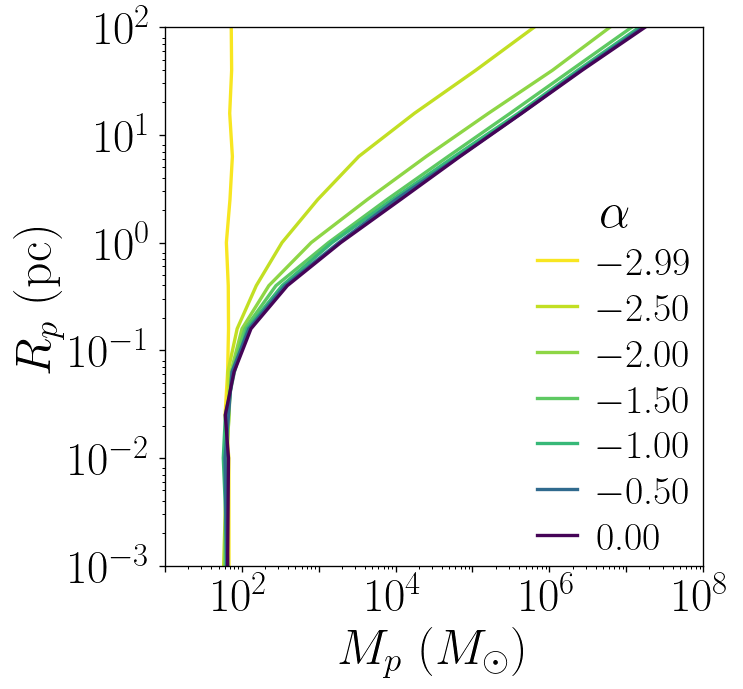

In [19]:
# ''' 
# Figure 16. fp=1 - contours for various power-law indices alpha

# purpose: show how limits in fp depends on alpha in one plot

# data: data/eDR3_plaws/contour_plots_alpha.npy
        
# source: farm:/dmbinaries/shooter_edr3/newgen_pipeline/sep_dist/contour_plotter.ipynb
# '''

# plt.rcParams['axes.labelsize'] = 30 
# plt.rcParams['axes.titlesize'] = 30 
# plt.rcParams['legend.title_fontsize'] = 28 
# plt.rcParams['font.size'] = 30 
# plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 8 
# plt.rcParams['legend.fontsize'] = 28 

fig = plt.figure(figsize=(6,5.55), dpi= 120)
ax = fig.add_subplot(111)

log_m_crit_mat, log_rslist = np.load('data/eDR3_plaws/contour_plots_alpha_nv.npy', allow_pickle = True)

alpha_list = np.arange(-3,0+0.5,0.5)
f_list = [1]

# Set color gradient of plots
cmap = plt.get_cmap('viridis')

# Plot the data
color_code = 0.99
color_code_list = [0.99,0.91,0.83,0.75,0.67,0.34,0.01]
color = cmap(color_code)

Na = len(alpha_list)
Nf = len(f_list)
for na in range(Na):
    alpha = alpha_list[na]
    if alpha < 0:
        str_alpha = '$-$' + str.format('{0:.2f}',-alpha)
    else:
        str_alpha = str.format('{0:.2f}',alpha)
    
    if str_alpha=='$-$3.00':
        str_alpha= r'$-2.99$'
    
    color_code = color_code_list[na]
    color = cmap(color_code)
    
    for nf in range(Nf):
        f = f_list[nf]
 

        ax.plot(10.**log_m_crit_mat[na,nf,:], 10.**log_rslist,
                label = str_alpha, alpha = 1, color = color)
        print(10**log_m_crit_mat[na,nf,:])
        # ax.set_title('General Constraints')
    
#         str_alpha_plot = str.format('{0:.0f}',alpha)
#         ax.text(1e-25,1e5, '$\\alpha = $' + str_alpha_plot, style='normal', fontsize = 28 * 2 / 3)
        
    #ax.grid()

ax.set_xlabel('$M_{p} \ (M_{\\odot})$',fontsize=fontsize)
ax.set_ylabel('$R_{p} \ (\\rm{pc})$',fontsize=fontsize)
ax.set_xlim(10**1.6,10**8)
ax.set_ylim(10**-3,10**2)
ax.set_xscale('log')
ax.set_yscale('log')

lgnd = ax.legend(frameon = False, title = '$\\alpha$ ', ncol = 1, handletextpad=0.5, handlelength = 1, 
                 loc='lower right', labelspacing = 0.25, columnspacing = 0.1, 
                bbox_to_anchor=(1.05, -0.05), fontsize = 24)
lgnd._legend_box.align = 'center'
lgnd.get_title().set_fontsize(30)
        
ax.set_xticks(np.logspace(2,8,7))
ax.set_yticks(np.logspace(-3,2,6))
ax.tick_params(direction='out', colors='k',
               grid_color='k', grid_alpha=0.25)
#ax.xaxis.ticklabel_format(useMathText=True)
#ax.yaxis.ticklabel_format(useMathText=True)
#ax.xaxis.set_major_formatter(logfmt)
#ax.yaxis.set_major_formatter(logfmt)

# Turning on minor tick marks for log-scaled plots


locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)
ax.xaxis.set_minor_locator(locmin_x)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# This allows us to manually modify tick labels
ax.set_xticks(np.logspace(1,8,8))
plt.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
for n in range(0,len(labels),2): labels[n] = ' ' 
    
ax.set_xticklabels(labels)

locmin_y = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9,0.1),numticks=15)
ax.yaxis.set_minor_locator(locmin_y)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.tick_params(axis='both',labelsize=28)

fig.tight_layout(pad = 0)
fig.savefig('figures/fig-constraints-alpha-v0.8.pdf', format = 'pdf', bbox_inches='tight', dpi = 120)

[[6.20435894e+01 6.27814635e+01 6.34120029e+01 6.46662851e+01
  8.51974009e+01 1.20619448e+02 2.19343144e+02 5.72516653e+02
  2.06256483e+03 1.07697803e+04 7.14286067e+04 4.61350466e+05]
 [9.83706010e+01 9.39636611e+01 8.76622190e+01 9.15733043e+01
  1.22957359e+02 1.60665063e+02 3.10918112e+02 8.38954452e+02
  3.33846561e+03 2.18108403e+04 1.29252394e+05 8.38820739e+05]
 [1.54366785e+02 1.53246828e+02 1.62075506e+02 1.71557767e+02
  1.92190398e+02 2.82371676e+02 6.31410916e+02 1.84124268e+03
  9.07342192e+03 6.10692045e+04 4.22929591e+05 2.90172555e+06]
 [5.70984495e+02 7.11983722e+02 6.46647601e+02 5.95959189e+02
  5.40051445e+02 8.75970793e+02 2.45697189e+03 2.14142332e+04
  1.16198113e+05 7.54608400e+05 5.65685958e+06 2.22528138e+07]]


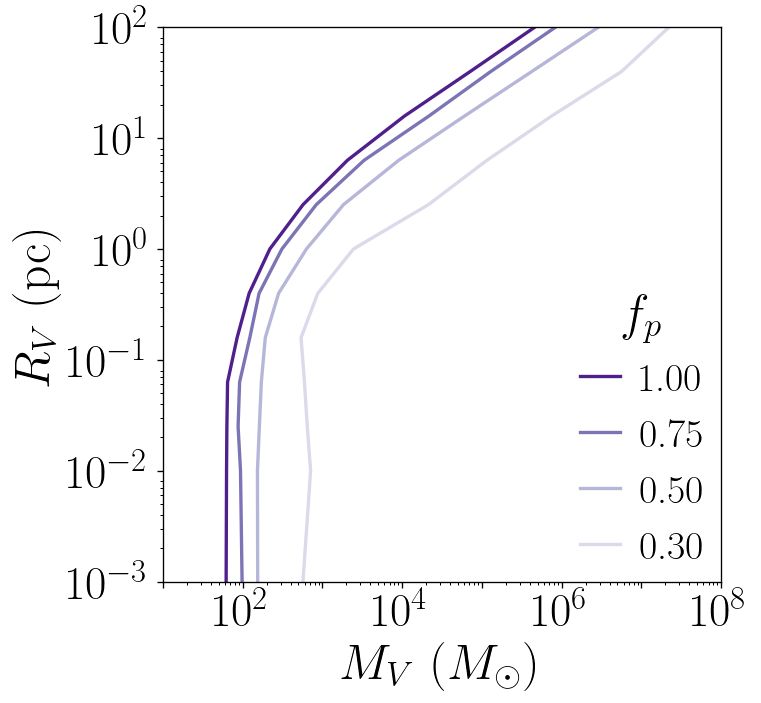

In [20]:
# ''' 
# Figure 17. NFW perturber constraints with canonical relations and varying perturber mass

# purpose: show how much more compact NFW perturbers must be to be excluded by data

# data: data/nfw_c_100_constraints.np
        
# source: farm:/dmbinaries/shooter_edr3/nfw_pipeline/sep_dist/contour_plotter_c_100.ipynb
# '''


log_rvlist, log_m_crit_mat = np.load('data/nfw_c_100_constraints_nv.npy', allow_pickle = True)

f_list = [1,0.75,0.5,0.3]
Nf = len(f_list)

fig = plt.figure(figsize=(6,6), dpi= 120)
ax = fig.add_subplot(111)

cmap = plt.get_cmap('Purples')
color_codes = [0.9, 0.65, 0.4, 0.25]

for nf in range(Nf):
    f = f_list[nf]
    str_f = str.format('{0:.2f}',f)  
        
    color_code = color_codes[nf]
    color = cmap(color_code)
    
    ax.plot(10.**log_m_crit_mat[nf,:], 10.**log_rvlist,
            label = str_f, lw = 2,
           color = color)
    
#     ax2.plot(10.**log_m_crit_mat[nf,:], 10.**log_mvlist)
    
ax.set_xlabel('$M_{V} \ (M_{\\odot})$',fontsize=fontsize)
ax.set_ylabel('$R_{V} \ (\\rm{pc})$',fontsize=fontsize)
ax.set_xlim(10**1,10**8)
ax.set_ylim(10**-3,10**2)
ax.set_xscale('log')
ax.set_yscale('log')

lgnd = ax.legend(frameon = False, title = '$f_{p}$', handletextpad=0.5,
             borderpad=0.25, handlelength = 1, bbox_to_anchor=(1.025, -0.025), loc='lower right', 
                labelspacing = 0.5, fontsize = 24)
lgnd._legend_box.align = 'center'

ax.set_xticks(np.logspace(2,8,7))
ax.set_yticks(np.logspace(-3,2,6))
ax.tick_params(direction='out', colors='k',
               grid_color='k', grid_alpha=0.25)
#ax.xaxis.ticklabel_format(useMathText=True)
#ax.yaxis.ticklabel_format(useMathText=True)
#ax.xaxis.set_major_formatter(logfmt)
#ax.yaxis.set_major_formatter(logfmt)

# Turning on minor tick marks for log-scaled plots


locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)
ax.xaxis.set_minor_locator(locmin_x)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# This allows us to manually modify tick labels
ax.set_xticks(np.logspace(1,8,8))
plt.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
for n in range(0,len(labels),2): labels[n] = ' ' 
    
ax.set_xticklabels(labels)

locmin_y = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9,0.1),numticks=15)
ax.yaxis.set_minor_locator(locmin_y)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.tick_params(axis='both',labelsize=28)

fig.savefig('figures/fig-nfw-constraints-c-100-v0.8.pdf', format = 'pdf', bbox_inches='tight', dpi = 120)

print(10**log_m_crit_mat)

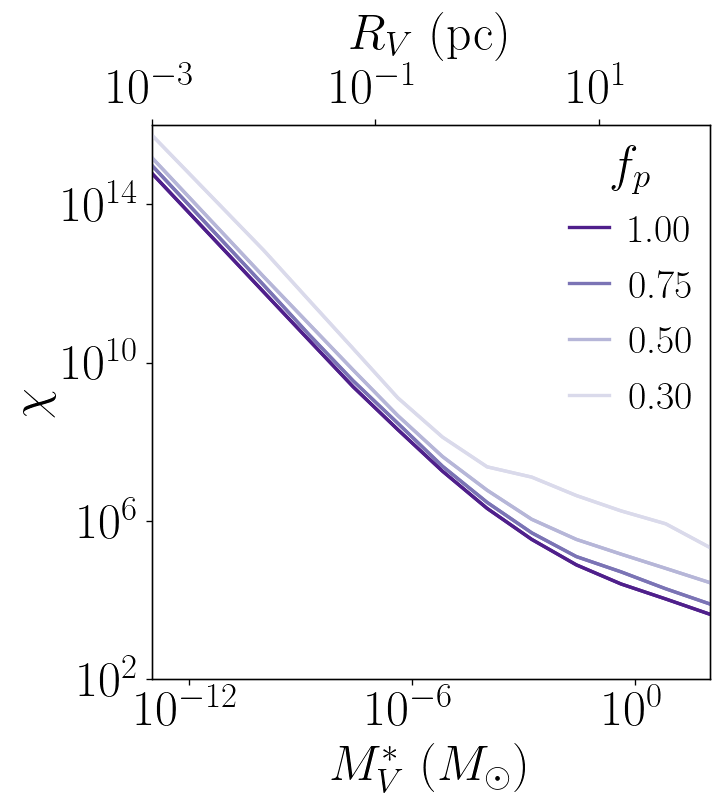

In [21]:
# ''' 
# Figure 18. NFW perturber constraints with canonical relations and varying perturber mass

# purpose: show how much more compact NFW perturbers must be to be excluded by data

# data: data/nfw_c_100_constraints.np
        
# source: farm:/dmbinaries/shooter_edr3/nfw_pipeline/sep_dist/contour_plotter_c_100.ipynb
# '''

from scipy.interpolate import interp1d

# --- Block to Set Parameters ---
# ---

## Conversion Factors:
kg_g = 1E-3
Msolar_kg = 5.02785E-31 # Msolar/kg
pc_m = 3.24078E-17 # pc/m
Gyr_yr = pow(10,-9) # Gyr/yr
yr_s = 3.17098E-8 # yr/s
km_m = 1/1000 # km/m
kg_GeV = 1.78266E-27 # [kg/(GeV/c**2)]
m_cm = pow(10,-2) # m/cm
pc_AU = 4.84814e-6 # pc/AU
AU_pc = 206265  # AU/pc

## fixed parameters 
#m1 = 0.5 # mass of primary (M_sol)
#m2 = 0.5 # mass of secondary (M_sol)
v0 = 240 # circular velocity (km/s) 
vesc = 533 # local escape velocity (km/s)
T = 10 # evolution time (Gyr)
#rho = 0.009 # Local DM Density (M_sol / pc**3) [Yoo]
rho_pdg = 0.39 # Local DM Density (GeV / cm3)
rho = 0.39 * (Msolar_kg) * (kg_GeV) * (pc_m)**(-3) * (m_cm)**(-3) #[Ed]

## constants
G = 4.30091e-3   # Grav Constant ([pc (M_solar)^-1 (km/s)**2])

## canonical nfw scale radius, concentration vs mass relations
h = 0.674 # present-day hubble constant
rho_c_standard = 1.87834e-29 * h * h # Today's Critical Density (g/cm**3)
rho_c = rho_c_standard * (Msolar_kg) * (kg_g) * (pc_m)**(-3) * (m_cm)**(-3)

log_rvlist, log_m_crit_mat = np.load('data/nfw_c_100_constraints_nv.npy', allow_pickle = True)

f_list = [1,0.75,0.5,0.3]
Nf = len(f_list)

fig = plt.figure(figsize=(6,6), dpi= 120)
ax = fig.add_subplot(111)
ax2 = ax.twiny()

def Mv_vs_Rv_log_(log_Rv):
    Mv = 4/3 * np.pi * 200. * rho_c * (10**log_Rv)**3
    return np.log10(Mv)

c = 100
log_mvlist = Mv_vs_Rv_log_(log_rvlist)

for nf in range(Nf):
    f = f_list[nf]
    str_f = str.format('{0:.2f}',f)  
    
    color_code = color_codes[nf]
    color = cmap(color_code)
    ax.plot(10.**log_mvlist,10.**log_m_crit_mat[nf,:] / 10.**log_mvlist,
            label = str_f, lw = 2,
           color = color)
    ax2.plot(10.**log_rvlist,10.**log_m_crit_mat[nf,:] / 10.**log_mvlist,
        label = str_f, lw = 2,
       color = color)
    #print(np.min(10.**log_m_crit_mat[nf,:] / 10.**log_mvlist))
    #log_mlist_alpha = log_mlist[log_mlist >= np.log10(m_crit_mat[na,0])]
    #interp_m_crit = interp1d(np.log10(m_crit_mat[na,:]), log_rslist, bounds_error = False, fill_value = [200])
    #ax.plot(m_crit_mat[na,:], 10**interp_m_crit(np.log10(m_crit_mat[na,:])), color = color, 
    #    label = '$\\alpha = $ ' + str_alpha, marker = 'o', markersize = 0.1)
    #ax.fill_between(10**log_mlist_alpha, 0, 10**interp_m_crit(log_mlist_alpha), color='gray', alpha=transparency_list[na])

ax.set_xlabel('$M_{V}^{*} \ (M_{\odot})$',fontsize=fontsize)
ax.set_ylabel('$\chi$',fontsize=fontsize)
# ax.set_title('General Constraints')
#ax.legend()

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10**Mv_vs_Rv_log_(-3),10**Mv_vs_Rv_log_(2)]) # limits chosen based on simulation data
ax.set_ylim([10**2,10**16]) # limits chosen based on simulation data

ax2.set_xlabel('$R_{V} \ ({\\rm pc})$', labelpad = 12,fontsize=fontsize)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(10**-3,10**2) # limits chosen based on simulation data
ax2.set_ylim([10**2,10**16]) # limits chosen based on simulation data

# This allows us to manually modify tick labels
ax.set_xticks([10**-12, 10**-6, 10**0])
plt.draw()

lgnd = ax.legend(frameon = False, title = '$f_{p}$', handletextpad=0.5,
             borderpad=0.25, handlelength = 1, bbox_to_anchor=(1.025, 0.42), loc='lower right', 
                labelspacing = 0.5, fontsize = 24)
lgnd._legend_box.align = 'center'
lgnd.get_title().set_fontsize(30)

fig.savefig('figures/fig-nfw-chi-v0.8.pdf', format = 'pdf', bbox_inches='tight', dpi = 120)

<Figure size 720x720 with 0 Axes>

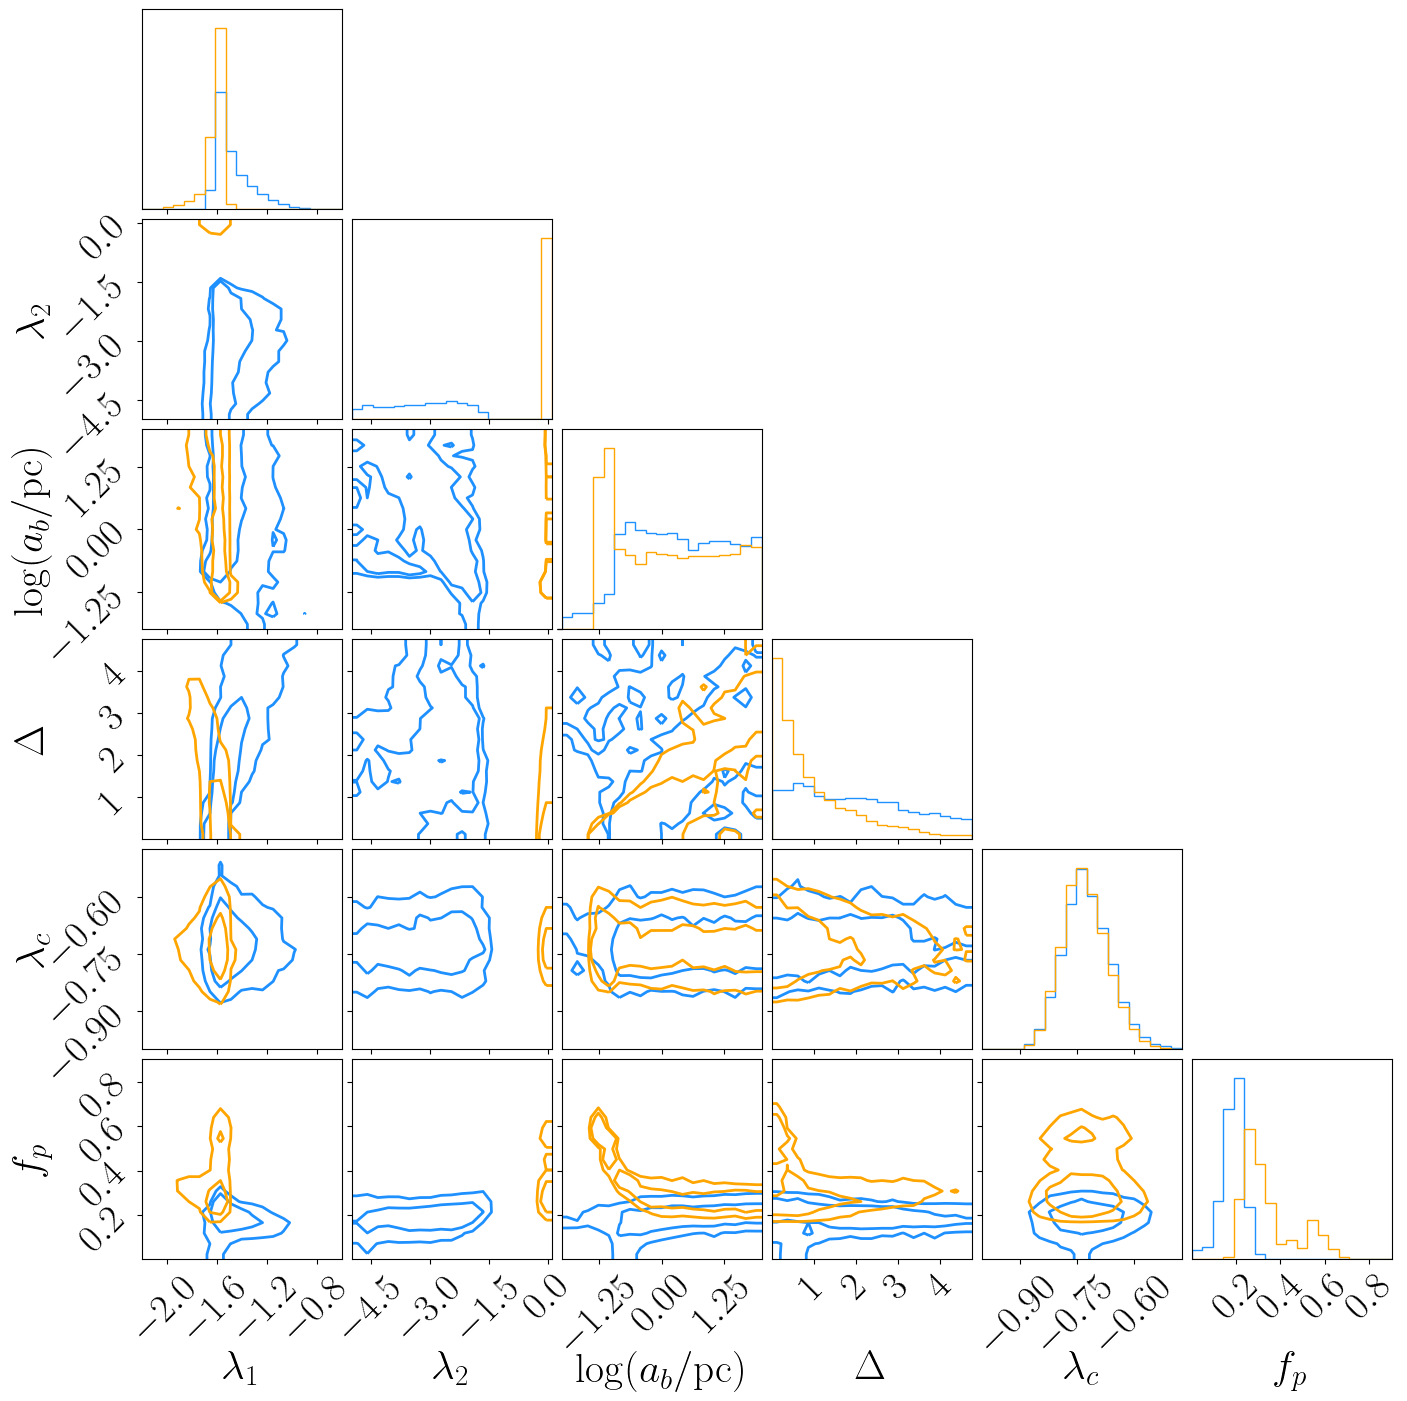

In [22]:
# ''' 
# Figure 19. Limits for varyining initial semimajor axis distribution models

# purpose: show how constraints vary with our assumptions of initial semimajor axis distribution

# data: 1. data/single_constraint_unconstrained.npy
#     2. data/single_constraint_constrained.npy
#     3. data/single_constraint.npy
        
# source: 1. farm:/dmbinaries/shooter_edr3/uni_pipeline/sep_dist/emcee_plotter_v0.3_sbp.ipynb
#     2. farm:/dmbinaries/shooter_edr3/uni_pipeline/sep_dist/emcee_plotter_v0.3_sbp_1.ipynb
#     3. farm:/dmbinaries/shooter_edr3/uni_pipeline/sep_dist/emcee_plotter_v0.3.ipynb
# '''

# gaussian plot

results_list = np.load('data/single_constraint_sbp_unconstrained_nv.npy', allow_pickle = True)

emcee_res = results_list[0]
flatchain_unconstrained = emcee_res[0]
flatchain_unconstrained[:,-2] = -flatchain_unconstrained[:,-2]
flatchain_unconstrained[:,-1] = 10**flatchain_unconstrained[:,-1]
catalog_data = results_list[1]

results_list = np.load('data/single_constraint_sbp_constrained_nv.npy', allow_pickle = True)

emcee_res = results_list[0]
flatchain_constrained = emcee_res[0]
flatchain_constrained[:,-2] = -flatchain_constrained[:,-2]
flatchain_constrained[:,-1] = 10**flatchain_constrained[:,-1]
catalog_data = results_list[1]

results_list = np.load('data/single_constraint_nv.npy', allow_pickle = True)

flatchain_sbp = np.zeros([120000,6])
emcee_res = results_list[0]
flatchain = emcee_res[0]
# flatchain_sbp[0,:] = 0.01
# flatchain_sbp[0,:] = 0.01
flatchain[:,0] = -flatchain[:,0]
flatchain[:,-1] = 10**flatchain[:,-1]
flatchain_sbp[:,0] = flatchain[:,0]
flatchain_sbp[:,-2] = flatchain[:,1]
flatchain_sbp[:,-1] = flatchain[:,2]

catalog_data = results_list[1]

# ---
import corner

fig_corner = plt.figure(figsize=(6,6), dpi= 120)

cmaps = ['cividis_r']
color_codes = np.array([0.85, 0.5, 0.15])

# plot the constraints
label_names = [r'$\lambda_{1}$',r'$\lambda_{2}$', r'$\log (a_{b} / {\rm pc})$', r'$\Delta$', r'$\lambda_{c}$', r'$f_{p}$'] 
figure = corner.corner(flatchain_unconstrained, labels = label_names, 
                  levels = (0.68, 0.95), title_kwargs={"fontsize": 18}, 
                  plot_datapoints = False, plot_density = False, color = 'dodgerblue', linewidth = 2,range = [(-2.2, -0.6), (-5, 0.1), (-2, 2),(0,4.75),(-1,-0.475),(0,0.9)],
                 bins = 19, label_kwargs={"fontsize": 30}, tick_kwargs={"fontsize": 30}, labelpad = 0.15)
corner.corner(flatchain_constrained, labels = label_names, 
                  levels = (0.68, 0.95), title_kwargs={"fontsize": 18}, 
                  plot_datapoints = False, plot_density = False, color = 'orange', linewidth = 2, range = [(-2.2, -0.6), (-5, 0.1), (-2, 2),(0,4.75),(-1,-0.475),(0,0.9)],
                 bins = 19, label_kwargs={"fontsize": 30}, tick_kwargs={"fontsize": 30}, labelpad = 0.15, fig = figure)

for ax in figure.get_axes():
    
    if str(ax) == "AxesSubplot(0.0719424,0.52518;0.143885x0.143885)":
        ax.set_yticks(np.array([-1.25,0,1.25]))
        
    if str(ax) == "AxesSubplot(0.223022,0.52518;0.143885x0.143885)":
        ax.set_yticks(np.array([-1.25,0,1.25]))
    if str(ax) == "AxesSubplot(0.374101,0.52518;0.143885x0.143885)":
        ax.set_xticks(np.array([-1.25,0,1.25]))
        ax.set_yticks(np.array([-1.25,0,1.25]))
    
    
    if str(ax) == "AxesSubplot(0.374101,0.0719424;0.143885x0.143885)":
        ax.set_xticks(np.array([-1.25,0,1.25]))
    if str(ax) == "AxesSubplot(0.374101,0.223022;0.143885x0.143885)":
        ax.set_xticks(np.array([-1.25,0,1.25]))
    if str(ax) == "AxesSubplot(0.374101,0.374101;0.143885x0.143885)":
        ax.set_xticks(np.array([-1.25,0,1.25]))
        
    ax.tick_params(axis='both',labelsize=28)
        
        
        
# corner.corner(flatchain_sbp, labels = label_names, 
#                   levels = (0.68, 0.95), title_kwargs={"fontsize": 18}, 
#                   plot_datapoints = False, plot_density = False, color = 'dimgray', linewidth = 2,
#                  bins = 19, label_kwargs={"fontsize": 30}, tick_kwargs={"fontsize": 30}, labelpad = 0.15, fig = figure)

# # plot the constraints
# label_names = [r'$\lambda_{1}$',r'$\lambda_{2}$', r'$\log (a_{b} / {\rm pc})$', r'$\Delta$', r'$\lambda_{c}$', r'$f_{p}$'] 
# figure = corner.corner(flatchain_unconstrained, labels = label_names, quantiles=[0.95], 
#                   levels = (0.68, 0.95), title_kwargs={"fontsize": 18}, 
#                   plot_datapoints = False, plot_density = False, color = 'darkblue', linewidth = 2,
#                  bins = 20, label_kwargs={"fontsize": 30}, tick_kwargs={"fontsize": 30}, labelpad = 0.15, 
#                       range = [[-1.8,0.5], [-5,0], [-2,2], [0,5], [0.45,1], [0,1]])
# corner.corner(flatchain_constrained, labels = label_names, quantiles=[0.95], 
#                   levels = (0.68, 0.95), title_kwargs={"fontsize": 18}, 
#                   plot_datapoints = False, plot_density = False, color = 'gold', linewidth = 2,
#                  bins = 20, label_kwargs={"fontsize": 30}, tick_kwargs={"fontsize": 30}, labelpad = 0.15, fig = figure, 
#              range = [[-1.8,0.5], [-5,0], [-2,2], [0,5], [0.45,1], [0,1]])
# corner.corner(flatchain_sbp, labels = label_names, quantiles=[0.95], 
#                   levels = (0.68, 0.95), title_kwargs={"fontsize": 18}, 
#                   plot_datapoints = False, plot_density = False, color = 'dimgray', linewidth = 2,
#                  bins = 20, label_kwargs={"fontsize": 30}, tick_kwargs={"fontsize": 30}, labelpad = 0.15, fig = figure, 
#              range = [[-1.8,0.5], [-5,0], [-2,2], [0,5], [0.45,1], [0,1]])

# log_mlist, log_f_2sigma = np.load('data/constraints_uni_v_Mp_sbp_unconstrained_nv.npy', allow_pickle = True)
# ax.plot(10**log_mlist,10**log_f_2sigma, color = 'darkblue', alpha = 1, label = 'Broken')

# log_mlist, log_f_2sigma = np.load('data/constraints_uni_v_Mp_sbp_constrained_nv.npy', allow_pickle = True)
# ax.plot(10**log_mlist,10**log_f_2sigma, color = 'gold', alpha = 1, label = 'Broken $(\lambda_{1} > \lambda_{2})$')

# log_mlist, log_f_2sigma = np.load('data/constraints_uni_v_Mp_nv.npy', allow_pickle = True)
# ax.plot(10**log_mlist,10**log_f_2sigma, color = 'dimgray', alpha = 1, label = 'Unbroken')


# ax.set_xlabel('$M_{p} \ (M_{\odot})$')
# ax.set_ylabel('$f_{p}$')

# ax.set_xscale('log')
# ax.set_yscale('linear')
# ax.set_xlim([10**1, 10**8])
# ax.set_ylim([-0.05,10**0])

# locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)
# ax.xaxis.set_minor_locator(locmin_x)
# ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# # This allows us to manually modify tick labels
# ax.set_xticks(np.logspace(1,8,8))
# plt.draw()

# labels = [item.get_text() for item in ax.get_xticklabels()]
# for n in range(0,len(labels),2): labels[n] = ' ' 
    
# ax.set_xticklabels(labels)

figure.savefig('figures/fig-corner-sbp-v0.8.pdf', format = 'pdf', bbox_inches='tight', dpi = 120)

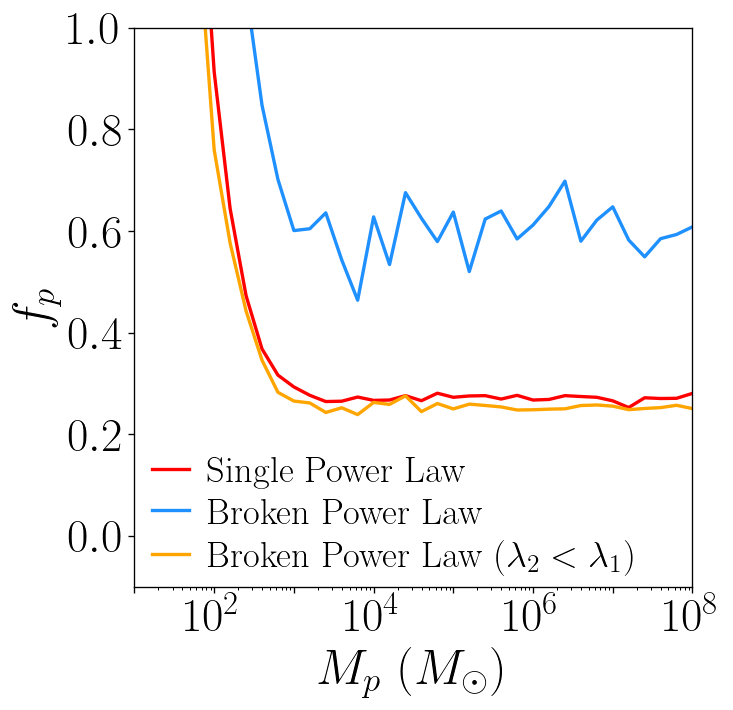

In [23]:
# ''' 
# Figure 20 Limits for varyining initial semimajor axis distribution models

# purpose: show how constraints vary with our assumptions of initial semimajor axis distribution

# data: 1. data/constraints_uni_v_Mp_sbp_unconstrained.npy
#     2. data/constraints_uni_v_Mp_sbp_constrained.npy
#     3. data/constraints_uni_v_Mp.npy
        
# source: 1. farm:/dmbinaries/shooter_edr3/uni_pipeline/sep_dist/emcee_plotter_v0.3_sbp.ipynb
#     2. farm:/dmbinaries/shooter_edr3/uni_pipeline/sep_dist/emcee_plotter_v0.3_sbp_1.ipynb
#     3. farm:/dmbinaries/shooter_edr3/uni_pipeline/sep_dist/emcee_plotter_v0.3.ipynb
# '''

fig_c_Mp = plt.figure(figsize=(6,6.05), dpi= 120)
ax = fig_c_Mp.add_subplot(111)

log_mlist, log_f_2sigma = np.load('data/constraints_uni_v_Mp_nv.npy', allow_pickle = True)
ax.plot(10**log_mlist,10**log_f_2sigma, color = 'red', alpha = 1, label = 'Single Power Law')

log_mlist, log_f_2sigma = np.load('data/constraints_uni_v_Mp_sbp_unconstrained_nv.npy', allow_pickle = True)
ax.plot(10**log_mlist,10**log_f_2sigma, color = 'dodgerblue', alpha = 1, label = 'Broken Power Law')

log_mlist, log_f_2sigma = np.load('data/constraints_uni_v_Mp_sbp_constrained_nv.npy', allow_pickle = True)
ax.plot(10**log_mlist,10**log_f_2sigma, color = 'orange', alpha = 1, label = 'Broken Power Law $(\lambda_{2} < \lambda_{1})$')


ax.set_xlabel('$M_{p} \ (M_{\odot})$', fontsize = fontsize)
ax.set_ylabel('$f_{p}$', fontsize = fontsize)

ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlim([10**1, 10**8])
ax.set_ylim([-0.1,1])

locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)
ax.xaxis.set_minor_locator(locmin_x)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# This allows us to manually modify tick labels
ax.set_xticks(np.logspace(1,8,8))
plt.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
for n in range(0,len(labels),2): labels[n] = ' ' 
    
ax.set_xticklabels(labels)

lgnd = ax.legend(frameon = False, handletextpad=0.5,
             borderpad=0.25, handlelength = 1, bbox_to_anchor=(0.95, -0.03), loc='lower right', 
                labelspacing = 0.25, fontsize = 22)
lgnd._legend_box.align = 'right'

ax.set_xticklabels(labels,fontsize=28)

ax.set_yticks(np.linspace(0,1,6))
ax.tick_params(axis='both',labelsize=28)

fig_c_Mp.savefig('figures/fig-constraints-mass-sbp-v0.8.pdf', format = 'pdf', bbox_inches='tight', dpi = 120)

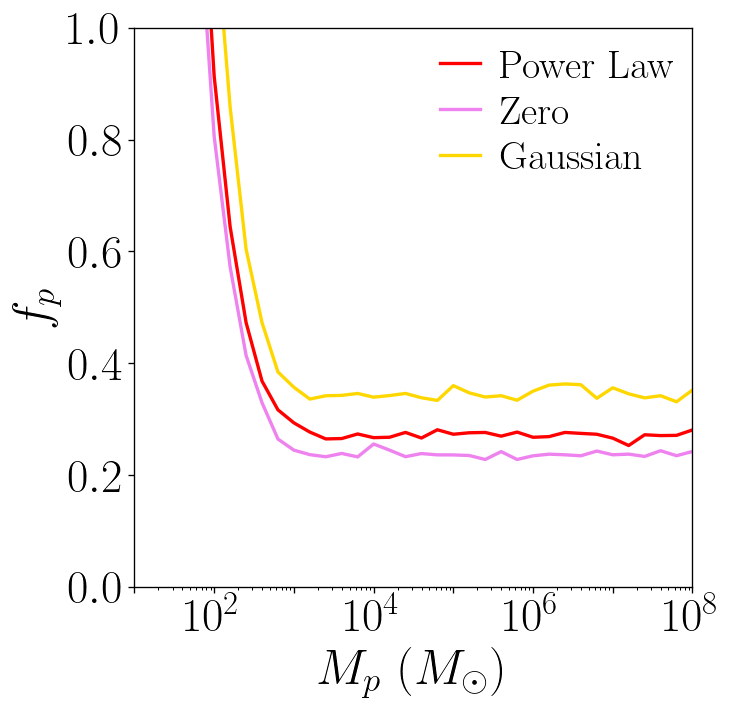

In [24]:
# ''' 
# Figure 21. Limits for various chance-alignment distributions

# purpose: show how constraints vary with our assumptions of the chance-alignment distribution

# data: 1. data/constraints_uni_v_Mp_nv.npy
#     2. data/constraints_uni_v_Mp_noca_nv.npy
#     3. data/constraints_uni_v_Mp_gaussian_max_ca_nv.npy
        
# source: 1. farm:/dmbinaries/shooter_edr3/uni_pipeline/sep_dist/emcee_plotter_v0.3.ipynb
#     2. farm:/dmbinaries/shooter_edr3/uni_pipeline/sep_dist/emcee_plotter_v0.3_noca.ipynb
#     3. farm:/dmbinaries/shooter_edr3/uni_pipeline/sep_dist/emcee_plotter_v0.3_gca.ipynb
# '''

fig_c_Mp = plt.figure(figsize=(6,6.05), dpi= 120)
ax = fig_c_Mp.add_subplot(111)

log_mlist, log_f_2sigma = np.load('data/constraints_uni_v_Mp_nv.npy', allow_pickle = True)
ax.plot(10**log_mlist,10**log_f_2sigma, color = 'red', alpha = 1, label = 'Power Law')

log_mlist, log_f_2sigma = np.load('data/constraints_uni_v_Mp_noca_nv.npy', allow_pickle = True)
ax.plot(10**log_mlist,10**log_f_2sigma, color = 'violet', alpha = 1, label = 'Zero')

log_mlist, log_f_2sigma = np.load('data/constraints_uni_v_Mp_gca_nv.npy', allow_pickle = True)
ax.plot(10**log_mlist,10**log_f_2sigma, color = 'gold', alpha = 1, label = 'Gaussian')

ax.set_xlabel('$M_{p} \ (M_{\odot})$', fontsize=fontsize)
ax.set_ylabel('$f_{p}$', fontsize=fontsize)

ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlim([10**1, 10**8])
ax.set_ylim([0,10**0])

locmin_x = mpl.ticker.LogLocator(base=10.0,subs=np.arange(0.2,0.9+0.1,0.1),numticks=15)
ax.xaxis.set_minor_locator(locmin_x)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

# This allows us to manually modify tick labels
ax.set_xticks(np.logspace(1,8,8))
plt.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
for n in range(0,len(labels),2): labels[n] = ' ' 
    
ax.set_xticklabels(labels)

lgnd = ax.legend(frameon = False, handletextpad=0.5,
             borderpad=0.25, handlelength = 1, bbox_to_anchor=(1.025, 0.68), loc='lower right', 
                labelspacing = 0.25, fontsize = 24)
lgnd._legend_box.align = 'right'

ax.tick_params(axis='both',labelsize=28)

fig_c_Mp.savefig('figures/fig-constraints-mass-ca-v0.8.pdf', format = 'pdf', bbox_inches='tight', dpi = 120)

$-1.605_{-0.030}^{+0.033}$
$0.208_{-0.030}^{+0.037}$


<Figure size 720x720 with 0 Axes>

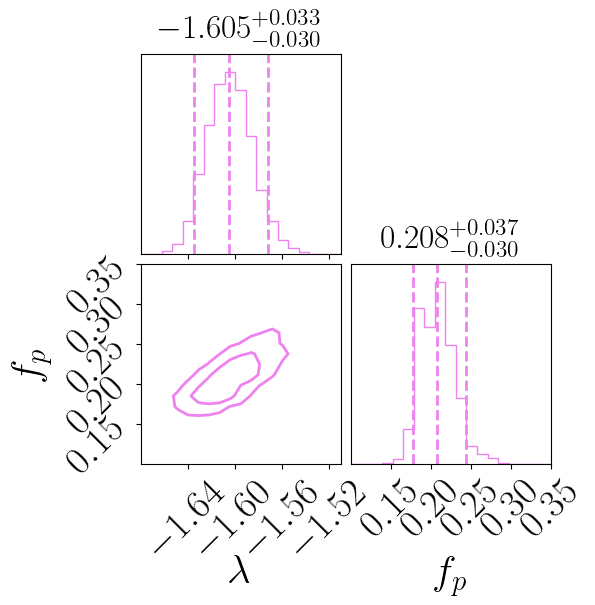

In [3]:
# ''' 
# Figure 22. Limits for no chance-alignment distribution

# purpose: show how constraints vary with our assumptions of the chance-alignment distribution

# data: 1. data/single_constraint_noca.py
        
# source: 1. farm:/dmbinaries/shooter_edr3/uni_pipeline/sep_dist/emcee_plotter_v0.3_noca.ipynb
# '''

# noca plot

results_list = np.load('data/single_constraint_noca_nv.npy', allow_pickle = True)

emcee_res = results_list[0]
flatchain_noca = emcee_res[0]
flatchain_noca[:,0] = -flatchain_noca[:,0]
flatchain_noca[:,-1] = 10**flatchain_noca[:,-1]
catalog_data = results_list[1]

# ---

import corner

fig_corner = plt.figure(figsize=(6,6), dpi= 120)

cmaps = ['cividis_r']
color_codes = np.array([0.85, 0.5, 0.15])

# plot the constraints
label_names = [r'$\lambda$', r'$f_{p}$'] 
figure = corner.corner(flatchain_noca, labels = label_names, quantiles=[0.05, 0.5, 0.95], 
                  levels = (0.68, 0.95), title_kwargs={"fontsize": 18}, 
                  plot_datapoints = False, plot_density = False, color = 'violet', linewidth = 2,
                 bins = 19, label_kwargs={"fontsize": 30}, tick_kwargs={"fontsize": 30}, labelpad = 0.15, range = [[-1.68, -1.51], [0.1,0.35]])

for ax in figure.get_axes():
    ax.tick_params(axis='both',labelsize=28)

axes = np.array(figure.axes).reshape((2 , 2))
labels =  [r'$\lambda$', r'$f_{p}$'] 
for i in range(2):
    ax = axes[i, i]
    mcmc = np.percentile(flatchain_noca[:, i], [5, 50, 95])
    if i == 1:
        mcmc = np.percentile(flatchain_noca[:, -1], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "${0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    print(txt)
    ax.set_title(txt, pad = 12, fontsize = 24)
    
#figure.savefig('fig-pm-corner.svg', format = 'svg', bbox_inches='tight', dpi = 120)
figure.savefig('figures/fig-corner-noca-v0.8.pdf', format = 'pdf', bbox_inches='tight', dpi = 120)

$-1.561_{-0.032}^{+0.029}$
$-4.110_{-1.698}^{+1.791}$
$-0.342_{-0.071}^{+0.090}$
$0.327_{-0.052}^{+0.030}$


<Figure size 720x720 with 0 Axes>

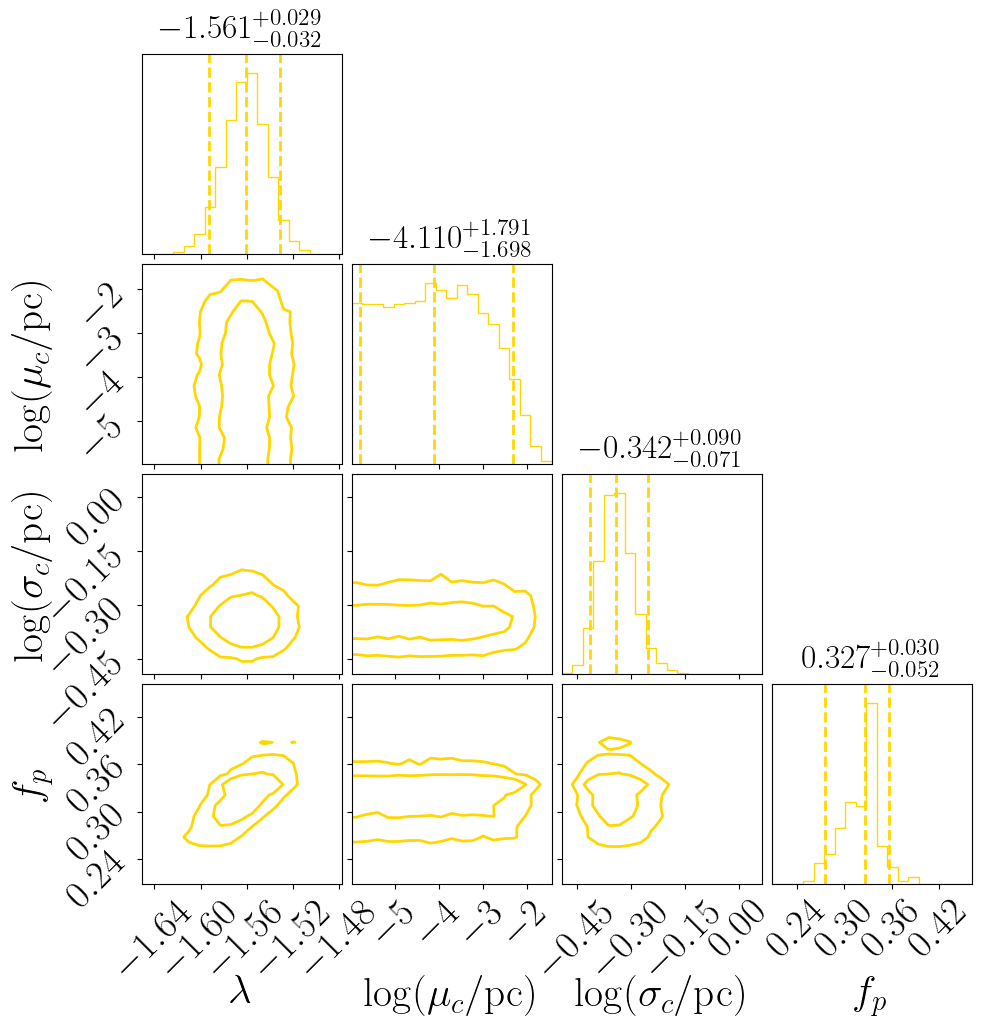

In [26]:
# ''' 
# Figure 23. Limits for Gaussian chance-alignment distribution

# purpose: show how constraints vary with our assumptions of the chance-alignment distribution

# data: 1. data/single_constraint_gca.py
        
# source: 1. farm:/dmbinaries/shooter_edr3/uni_pipeline/sep_dist/emcee_plotter_v0.3_gca.ipynb
# '''

# gaussian plot

results_list = np.load('data/single_constraint_gca_nv.npy', allow_pickle = True)

emcee_res = results_list[0]
flatchain_gca = emcee_res[0]
flatchain_gca[:,0] = -flatchain_gca[:,0]
# flatchain_gca[:,1] = 10**flatchain_gca[:,1]
# flatchain_gca[:,2] = 10**flatchain_gca[:,2]
flatchain_gca[:,-1] = 10**flatchain_gca[:,-1]
catalog_data = results_list[1]

# ---

import corner

fig_corner = plt.figure(figsize=(6,6), dpi= 120)

cmaps = ['cividis_r']
color_codes = np.array([0.85, 0.5, 0.15])

# plot the constraints
label_names =  [r'$\lambda$', r'$\log (\mu_{c} / {\rm pc})$',r'$\log (\sigma_{c} / {\rm pc})$', r'$f_{p}$'] 
figure = corner.corner(flatchain_gca, labels = label_names, quantiles=[0.05, 0.5, 0.95], 
                  levels = (0.68, 0.95), title_kwargs={"fontsize": 18}, 
                  plot_datapoints = False, plot_density = False, color = 'gold', linewidth = 2,
                 bins = 19, label_kwargs={"fontsize": 30}, tick_kwargs={"fontsize": 30}, labelpad = 0.15)

for ax in figure.get_axes():
    ax.tick_params(axis='both',labelsize=28)

axes = np.array(figure.axes).reshape((4, 4))
labels_names =  [r'$\lambda$', r'$\log (\mu_{c} / {\rm pc})$',r'$\log (\sigma_{c} / {\rm pc})$', r'$f_{p}$'] 
for i in range(4):
    ax = axes[i, i]
    mcmc = np.percentile(flatchain_gca[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "${0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], label_names[i])
    print(txt)
    ax.set_title(txt, pad = 12, fontsize = 24)
    
# for ax in figure.get_axes():
#     print(ax)
    
#     if str(ax) == "AxesSubplot(0.131579,0.684211;0.263158x0.263158)":
#         ax.set_xticks([1.55,1.60,1.65])
    
#     if str(ax) == "AxesSubplot(0.131579,0.407895;0.263158x0.263158)":
#         ax.set_xticks([1.55,1.60,1.65])
#         ax.set_yticks([0.60, 0.75, 0.90])
        
#     if str(ax) == "AxesSubplot(0.131579,0.131579;0.263158x0.263158)":
#         ax.set_xticks([1.55,1.60,1.65])
        
#         ax.set_yticks([0.20, 0.25, 0.30])
#         ax.set_ylim([0.16,0.32])
    
#     if str(ax) == "AxesSubplot(0.407895,0.407895;0.263158x0.263158)":
#         ax.set_xticks([0.60, 0.75, 0.90])
    
#     if str(ax) == "AxesSubplot(0.407895,0.131579;0.263158x0.263158)":
#         ax.set_xticks([0.60, 0.75, 0.90])
        
#     if str(ax) == "AxesSubplot(0.407895,0.131579;0.263158x0.263158)":
#         ax.set_yticks([0.20, 0.25, 0.30])
#         ax.set_ylim([0.16,0.32])
    
#     if str(ax) == "AxesSubplot(0.684211,0.131579;0.263158x0.263158)":
#         ax.set_xticks([0.20, 0.25, 0.30])
#         ax.set_xlim([0.16,0.32])

# Add line on limit

# axes = np.array(figure.axes).reshape((2, 2))
# labels = ['\lambda', 'f_{p}'] 
# for i in range(3):
#     ax = axes[i, i]
#     mcmc = np.percentile(flatchain[:, i], [5, 50, 95])
#     q = np.diff(mcmc)
#     txt = "${0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}$"
#     txt = txt.format(mcmc[1], q[0], q[1], labels[i])
#     print(txt)
#     ax.set_title(txt, pad = 10)
    
# ax = axes[1, 1]
# ax.axvline(x = mcmc[1] + q[1], color="r", lw = 2, alpha = 0.75)


#     if str(ax) == "AxesSubplot(0.181818,0.181818;0.363636x0.363636)":
#         ax.set_xlim([1.45,1.64])
#         ax.set_xticks([1.45,1.50,1.55, 1.60])
        
#         ax.set_ylim([0.1,0.32])
#         ax.set_yticks([0.15,0.2,0.25, 0.3])

#     if str(ax) == "AxesSubplot(0.563636,0.181818;0.363636x0.363636)": 
#         ax.set_xlim([0.1,0.32])
#         ax.set_xticks([0.15,0.2,0.25, 0.3])
        
#     if str(ax) == "AxesSubplot(0.181818,0.563636;0.363636x0.363636)":
#         ax.set_xlim([1.45,1.64])
#         ax.set_xticks([1.45,1.50,1.55, 1.60])
        
#     if str(ax) == "AxesSubplot(0.563636,0.563636;0.363636x0.363636)":
#         ax.set_xlim([1.45,1.64])
#         #ax.set_xticks([0.15,0.2,0.25, 0.3])

#figure.savefig('fig-pm-corner.svg', format = 'svg', bbox_inches='tight', dpi = 120)
figure.savefig('figures/fig-corner-gca-v0.8.pdf', format = 'pdf', bbox_inches='tight', dpi = 120)